# 1. Sequence Retrieval, Consensus Tree and newick-iTOL visualisation Using QIIME2 and DADA 
Assessing the Role of Microbial Genera in Corrosion Failure of Water and Cooling Systems

## 1.1. Introduction 
This notebook follows the next steps of the previous notebook 4. The main objective is to sequence, make a newick tree hierarchical tree for each of the tree base dataframes 
Core taxa tree (~60 highest abundance bacteria)  
Usual suspects tree (known corrosion-causing bacteria)   
Checked genera tree (statistically significant bacteria)  
Then making the sequence of the merged three dataframes core_check_usual_taxa.  
This notebook builds upon findings from notebook 4, focusing on the phylogenetic analysis of bacterial genera associated with corrosion in water and cooling systems. Through the systematic retrieval and analysis of 16S rRNA sequences from the NCBI GenBank database, we aim to construct phylogenetic trees for three distinct bacterial groups: the core taxa representing the 60 most abundant bacteria, the usual suspects comprising known corrosion-causing bacteria, and the checked genera identified through statistical significance.
The analysis begins with individual tree construction for each group, followed by the creation of a merged phylogenetic tree incorporating all three datasets. This approach serves multiple purposes: it validates our statistical findings against known corrosion-causers, reveals evolutionary relationships that might explain shared mechanisms, and provides context for newly identified bacteria. By implementing UPGMA methodology and bootstrap analysis, we ensure robust tree construction and reliability assessment.
Our workflow encompasses sequence retrieval from NCBI, data validation, sequence alignment, and consensus tree construction. The resulting phylogenetic relationships will illuminate community power dynamics and bacterial assembly patterns, establishing a foundation for subsequent metabolic pathway analysis through PICRUSt. This understanding is crucial for the final machine learning ensemble, where we will integrate these findings with physicochemical data from Repository 1_Physicochemical.
The notebook employs various safety measures and optimization techniques, including controlled server interaction and comprehensive error handling, ensuring reliable data collection and analysis. Through this systematic approach, we aim to deepen our understanding of microbially influenced   corrosion while establishing a robust framework for future analyses.
  
MIC/  
├── 2_Micro/  
    ├── data_qiime/          # QIIME2 analysis results  
    │   ├── sequences/       # Raw and processed sequences  
    │   ├── quality/         # Quality analysis results  
    │   └── trees/          # Phylogenetic trees  
    └── notebooks/  
        └── sequences_qiime.ipynb  
        

I am having problems installilng packages from the terminal, so I am installing the biophyton from here.

## 1.2 Preprocessing the data 
This notebook has been worked in colab and in vsc, the code is silence eitherway.
Mounting the data in colab

In [ ]:
'''from google.colab import drive  #silence for vscode
drive.mount('/content/drive')

#change the path
os.chdir('/content/drive/My Drive/MIC')'''

In [ ]:
!pip install biopython
from IPython import get_ipython
from IPython.display import display
!pip install ete3
!pip install pyqt5
!pip install dendropy

'\nfrom Bio import Phylo\nimport matplotlib.pyplot as plt\nplt.figure(figsize=(15, 10))  # Adjust size as needed\nPhylo.draw(consensus_tree)\nplt.show()\n'

## 1.3. Importing the necesary libraries

In [1]:
# Standard library imports
import os
import json
import tempfile
import time
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Generator
from dataclasses import dataclass
from math import log
from random import choice
from datetime import datetime
import shutil
import logging
from typing import Tuple, List, Dict 

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Biopython imports
from Bio import Entrez, SeqIO, AlignIO, Phylo
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio.Phylo.Consensus import majority_consensus

# QIIME2 imports
#import qiime2
#from qiime2.plugins import demux, dada2, phylogeny, alignment, diversity
#import qiime2.plugins.feature_table.methods as feature_table_methods
#import qiime2.plugins.feature_table.visualizers as visualizers

# biom imports
#from biom.table import Table
#from biom.util import biom_open
#from biom import load_table

# Tree visualization imports
from ete3 import (
    Tree as EteTree,  # Renamed to avoid conflict
    TreeStyle, 
    NodeStyle, 
    TextFace, 
    RectFace, 
    faces, 
    CircleFace
)
import dendropy
from dendropy import Tree as DendroTree  # Renamed to avoid conflict

# Subprocess for external commands
import subprocess

## 1.4. Folder Creation for the Results: Data_tree
dedicated folder to keep the results and bootstraping of the present notebook  

In [ ]:
# For VSCode
output_dir = Path("/home/beatriz/MIC/2_Micro/data_qiime")
# Create output directory if it doesn't exist
output_dir.mkdir(parents=True, exist_ok=True)
bootstrap_dir = output_dir / "bootstrapping"
bootstrap_dir.mkdir(exist_ok=True)

input_dir = Path("/home/beatriz/MIC/2_Micro/data_tree")
original_sequences_file = input_dir / "final_sequences_integrate.fasta"

# For Colab
'''
bootstrap_dir = base_dir / "bootstrapping"
bootstrap_dir.mkdir(exist_ok=True)

abundance_excel= Path("/content/drive/MyDrive/MIC/data_picrust/merged_to_sequence.xlsx")
large_dir = Path("/content/drive/MyDrive/MIC/")
input_galaxy = large_dir / "data_galaxies"
data_qiime = Path("/content/drive/MyDrive/MIC/data_qiime")
input_dir = Path("/content/drive/MyDrive/MIC/data_qiime")
newick_path = Path("/content/drive/MyDrive/MIC/data_galaxies/Galaxy7-PICRUSt2-Full-pipeline-on-data-2-and-data-1-Tree-reference-study-16S-sequences.newick")
output_base = Path("/content/drive/MyDrive/MIC/data_picrust/output_base")
tree_path = Path("/content/drive/MyDrive/MIC/data_qiime/consensus_tree_integrated_ncbi.newick")
output_galaxy = input_dir / "output_galaxy"
output_galaxy.mkdir(parents=True, exist_ok=True)
'''

'\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\nbase_dir = Path(\'/content/drive/My Drive/MIC/data\')\nbootstrap_dir = base_dir / "bootstrapping"\nbootstrap_dir.mkdir(exist_ok=True)\n'

## 1.5. Loadging, cleaning and preparing the dataframe
This notebook is made specially to run one individual dataframe coming from : core_taxa and checked_genera come from book 3 directory /data. Usual genera was built on notebook 3 but has been re-think on notebook 4. The merged dataframe core_check_usual_taxa was built from the merge of all three trees and was built also on notebook 4. 
For simplicity the notebook is aim to run only one of this individual files only to change the origin import in excel and the color scheme in the iTOL section, which is done by silence and select the source_type in the next cell. 

In [4]:
#loading only one of each of the three dataframes for every complete run of the notebook
#source_type = 'checked'  # genera come from book 3 directly directory /data
#source_type = 'usual' #  re-made come from book 4 directory /data_ref
#source_type = 'core'   # genera come from book 3 directly directory /data
source_type = 'check_core_usual' # made on book 4 directory /data_ref

In [3]:
#selected = pd.read_excel("data/finalist_dfs.xlsx", sheet_name='core_taxa', header=[0,1,2,3,4,5,6,7]) # for individual or two combinations activate
selected = pd.read_excel('~/MIC/2_Micro/data_Ref/merged_to_sequence.xlsx', sheet_name='core_check_usual_taxa', header=[0,1,2,3,4,5,6,7]) # for the mixture of the 3 df
# Drop first row (index 0) and first column in one chain
selected = selected.drop(index=0).drop(selected.columns[0], axis=1)
# Remove 'Unnamed' level names
selected.columns = selected.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
# If the dataframe has Nan in sites it will replace it with Source
selected['Sites'] = selected['Sites'].fillna('Source')
# Fill the other index with nothing
selected = selected.fillna(' ')
# Setting index to Sites
selected= selected.set_index("Sites")
selected_taxa = selected.T

In [4]:
selected.head()

,Category,Rhodocyclales_Rhodocyclaceae_Azospira,Actinomycetales_Dermabacteraceae_Brachybacterium,Actinomycetales_Brevibacteriaceae_Brevibacterium,Erysipelotrichales_Erysipelotrichaceae_Bulleidia,Clostridiales_Clostridiaceae_Clostridium,Actinomycetales_Corynebacteriaceae_Corynebacterium,Lactobacillales_Enterococcaceae_Enterococcus,Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria,Oceanospirillales_Halomonadaceae_Halomonas,...,Actinomycetales_Propionibacteriaceae_Tessaracoccus,Clostridiales_Peptococcaceae_Thermincola,Spirochaetales_Spirochaetaceae_Treponema,Burkholderiales_Oxalobacteraceae_Oxalobacteraceae_unclassified,Burkholderiales_Comamonadaceae_Variovorax,Anaerolineales_Anaerolinaceae_Wchb1-05,Desulfobacterales_Desulfobacteraceae_Desulfobacterium,Desulfobacterales_Desulfobulbaceae_Desulfobulbus,Gallionellales_Gallionellaceae_Gallionella,Alteromonadales_Shewanellaceae_Shewanella
,,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,...,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria
,,Proteobacteria,Actinobacteria,Actinobacteria,Firmicutes,Firmicutes,Actinobacteria,Firmicutes,Firmicutes,Proteobacteria,...,Actinobacteria,Firmicutes,Spirochaetes,Proteobacteria,Proteobacteria,Chloroflexi,Proteobacteria,Proteobacteria,Proteobacteria,Proteobacteria
,,Betaproteobacteria,Actinobacteria,Actinobacteria,Erysipelotrichi,Clostridia,Actinobacteria,Bacilli,Clostridia,Gammaproteobacteria,...,Actinobacteria,Clostridia,Spirochaetes,Betaproteobacteria,Betaproteobacteria,Anaerolineae,Deltaproteobacteria,Deltaproteobacteria,Betaproteobacteria,Gammaproteobacteria
,,Rhodocyclales,Actinomycetales,Actinomycetales,Erysipelotrichales,Clostridiales,Actinomycetales,Lactobacillales,Thermoanaerobacterales,Oceanospirillales,...,Actinomycetales,Clostridiales,Spirochaetales,Burkholderiales,Burkholderiales,Anaerolineales,Desulfobacterales,Desulfobacterales,Gallionellales,Alteromonadales
,,Rhodocyclaceae,Dermabacteraceae,Brevibacteriaceae,Erysipelotrichaceae,Clostridiaceae,Corynebacteriaceae,Enterococcaceae,Thermoanaerobacteraceae,Halomonadaceae,...,Propionibacteriaceae,Peptococcaceae,Spirochaetaceae,Oxalobacteraceae,Comamonadaceae,Anaerolinaceae,Desulfobacteraceae,Desulfobulbaceae,Gallionellaceae,Shewanellaceae
,,Azospira,Brachybacterium,Brevibacterium,Bulleidia,Clostridium,Corynebacterium,Enterococcus,Gelria,Halomonas,...,Tessaracoccus,Thermincola,Treponema,Oxalobacteraceae_unclassified,Variovorax,Wchb1-05,Desulfobacterium,Desulfobulbus,Gallionella,Shewanella
,,110,140,145,154,214,229,300,334,354,...,715,719,731,853,863,867,264,265,332,656
Sites,,,,,,,,,,,,,,,,,,,,,
site_1,3.0,26.928048,0,0,0,0,0,0,0.021542,0,...,0,0,0,0,1.658768,0,0,0.17234,0,0.107712
site_2,1.0,1.85923,0,0,0,0,0,0,0,0,...,0,0,0,0,2.162777,0,0,0.018972,0,0.132802


# 2. Sequences Retrieval
## 2.1 NBCI communication setup

In [16]:
'''# Comunicating with the NCBI
from config import NCBI_API_KEY, NCBI_EMAIL
Entrez.email = NCBI_EMAIL
Entrez.api_key = NCBI_API_KEY'''

'# Comunicating with the NCBI\nfrom config import NCBI_API_KEY, NCBI_EMAIL\nEntrez.email = NCBI_EMAIL\nEntrez.api_key = NCBI_API_KEY'

In [17]:
'''def setup_logging():
    """Configure logging to both file and console"""
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler('sequence_retrieval.log'),
            logging.StreamHandler()
        ]
    )'''

'def setup_logging():\n    """Configure logging to both file and console"""\n    logging.basicConfig(\n        level=logging.INFO,\n        format=\'%(asctime)s - %(levelname)s - %(message)s\',\n        handlers=[\n            logging.FileHandler(\'sequence_retrieval.log\'),\n            logging.StreamHandler()\n        ]\n    )'

## 2.2. Sequence Collection

In [18]:
# Extract Genera from the multi-index and filter out empty strings
genera = [genus for genus in selected.columns.get_level_values(6).to_list() if genus.strip()]

## 2.3. Retriving Data from the NCBI
Following code is silent, so that I dont run it again by mistake and ask again the accession numbers to the NCBI

In [19]:
'''# Dictionary to store the results
results = {}
def search_sequences(
    genus: str,
    entrez: object,
    max_retries: int = 5,
    base_delay: int = 30,
    max_delay: int = 120
) -> Optional[List[str]]:
    """
    Search for sequences with improved error handling and validation.
    
    Args:
        genus: The genus name to search for
        entrez: Entrez object with configured email and API key
        max_retries: Maximum number of retry attempts
        base_delay: Initial delay between retries in seconds
        max_delay: Maximum delay between retries in seconds
    
    Returns:
        List of sequence IDs or None if unsuccessful
    """
    if not isinstance(genus, str) or not genus.strip():
        raise ValueError("Genus must be a non-empty string")
    if not hasattr(entrez, 'email') or not entrez.email:
        raise RuntimeError("Entrez email configuration missing")
    
    retry_count = 0
    delay = base_delay

    while retry_count < max_retries:
        try:
            search_term = (f"{genus}[Organism] AND " "(16S[All Fields] OR 16S ribosomal RNA[All Fields] OR "
                "16S rRNA[All Fields]) AND " "500:2000[Sequence Length]")
            
            logging.info(f"Attempting search for {genus} (attempt {retry_count + 1}/{max_retries})")
            # Search NCBI database
            handle = entrez.esearch(db="nucleotide", term=search_term, retmax=100)
            
            try:
                record = entrez.read(handle)
                # Add extra delay after successful read
                time.sleep(5)

            except entrez.Parser.ValidationError as ve:
                logging.error(f"NCBI validation error for {genus}: {str(ve)}")
                retry_count += 1
                continue
            finally:
                handle.close()
            
            sequence_count = len(record.get('IdList', []))
            logging.info(f"Found {sequence_count} sequences for {genus}")
                        
            if sequence_count > 0:
                return record['IdList']
            
            logging.warning(f"No sequences found for {genus}")
            return[]
            
        except entrez.HTTPError as he:
            logging.error(f"NCBI HTTP error: {str(he)}")
        except entrez.URLError as ue:
            logging.error(f"NCBI connection error: {str(ue)}")
        except Exception as e:
            logging.error(f"Unexpected error: {str(e)}")

        retry_count += 1
        if retry_count < max_retries:
            wait_time = min(delay * (2 ** retry_count), max_delay)
            logging.info(f"Waiting {wait_time} seconds before retry...")
            time.sleep(wait_time)

            if retry_count >=max_retries:
                logging.error(f"Max retries ({max_retries}) reached for {genus}")
                return None
        return []
# Save progress after each genus
def retrieve_sequences(
    genera: List[str],
    entrez: object,
    output_file: str = "sequence_results.txt",
    progress_file: str = "retrieval_progress.json"
) -> Dict[str, List[str]]:
    """
    Retrieve sequences with comprehensive logging, error handling with progress saving
    
    Args:
        genera: List of genus names
        entrez: Configured Entrez object
        output_file: Path to save detailed results
    
    Returns:
        Dictionary mapping genera to their sequence IDs
    """
    setup_logging()
    logging.info(f"Starting sequence retrieval for {len(genera)} genera")
    
    # Load any existing progress
    results = {}
    if os.path.exists(progress_file):
        try:
            with open(progress_file, 'r') as f:
                content = f.read()
                if content.strip():  # Check if file is not empty
                    results = json.loads(content)
                    logging.info(f"Loaded {len(results)} existing results")
                else:
                    logging.info("Progress file exists but is empty")
        except json.JSONDecodeError:
            logging.warning("Could not decode progress file, starting fresh")
    
    missing_genera = []
    start_time = datetime.now()
    
    total_genera = len(genera)
    processed_count = len(results)

    for genus in genera:
        # Skip if already processed
        if genus in results:
            logging.info(f"Skipping {genus} - already processed")
            continue

        processed_count += 1
        logging.info(f"Processing {genus} ({processed_count}/{total_genera})")
        
        sequence_ids = search_sequences(genus, entrez)
        
        if sequence_ids:
            results[genus] = sequence_ids
            # Save progress after each successful retrieval
            with open(progress_file, 'w') as f:
                json.dump(results, f)
        else:
            missing_genera.append(genus)
        
        success_rate = (len(results) / processed_count) * 100
        logging.info(f"Current success rate: {success_rate:.1f}%")
        
        time.sleep(30)
    
    # Generate summary
    elapsed_time = datetime.now() - start_time
    summary = f"""
    Sequence Retrieval Summary
    Total genera processed: {total_genera}
    Successful retrievals: {len(results)}
    Failed retrievals: {len(missing_genera)}
    Success rate: {(len(results)/total_genera)*100:.1f}%
    Total time elapsed: {elapsed_time}

    Successful Genera:
    {'-' * 20}
    """ + '\n'.join(f"- {genus}: {len(ids)} sequences" for genus, ids in results.items()) + f"""

    Missing Genera:
    {'-' * 20}
    """ + '\n'.join(f"- {genus}" for genus in missing_genera)
    
    # Save summary to file
    with open(output_file, 'w') as f:
        f.write(summary)
    
    return results'''

'# Dictionary to store the results\nresults = {}\ndef search_sequences(\n    genus: str,\n    entrez: object,\n    max_retries: int = 5,\n    base_delay: int = 30,\n    max_delay: int = 120\n) -> Optional[List[str]]:\n    """\n    Search for sequences with improved error handling and validation.\n    \n    Args:\n        genus: The genus name to search for\n        entrez: Entrez object with configured email and API key\n        max_retries: Maximum number of retry attempts\n        base_delay: Initial delay between retries in seconds\n        max_delay: Maximum delay between retries in seconds\n    \n    Returns:\n        List of sequence IDs or None if unsuccessful\n    """\n    if not isinstance(genus, str) or not genus.strip():\n        raise ValueError("Genus must be a non-empty string")\n    if not hasattr(entrez, \'email\') or not entrez.email:\n        raise RuntimeError("Entrez email configuration missing")\n    \n    retry_count = 0\n    delay = base_delay\n\n    while retry_

In [20]:
'''# Calling the function
results = retrieve_sequences(genera, Entrez)'''

'# Calling the function\nresults = retrieve_sequences(genera, Entrez)'

## 2.4 Sucess Rate Sequenced Genera

In [21]:
'''print(f"Initial number of genera: {len(genera)}")
print(f"Number of genera with sequences: {len(results)}")
print(f"Success rate: {(len(results)/len(genera)*100):.2f}%")

# Which genera got sequences:
print("\nGenera with sequences:")
for genus, seq_list in results.items():
    print(f"{genus}: {len(seq_list)} sequences")'''

'print(f"Initial number of genera: {len(genera)}")\nprint(f"Number of genera with sequences: {len(results)}")\nprint(f"Success rate: {(len(results)/len(genera)*100):.2f}%")\n\n# Which genera got sequences:\nprint("\nGenera with sequences:")\nfor genus, seq_list in results.items():\n    print(f"{genus}: {len(seq_list)} sequences")'

## 2.5. Resulting accension numbers

In [22]:
'''# Print the results
for genus, ids in results.items():
    print(f"{genus}: {ids}")'''

'# Print the results\nfor genus, ids in results.items():\n    print(f"{genus}: {ids}")'

In [23]:
'''# Create a DataFrame from the dictionary
df_accension = pd.DataFrame(list(results.items()), columns=['Genus', 'IDs'])
df_accension.head(31)'''

"# Create a DataFrame from the dictionary\ndf_accension = pd.DataFrame(list(results.items()), columns=['Genus', 'IDs'])\ndf_accension.head(31)"

## 2.6. Merging Taxa, Abundance and Accension Numbers on a dataframe

In [24]:
'''# Merge the two DataFrames on the 'Genus' column
taxa_accension = pd.merge(selected_taxa, df_accension, on='Genus')
# Save the merged sequences to use making the dendrogram notebook
taxa_accension.to_csv('data_tree/taxa_accension.csv', index=False)'''

"# Merge the two DataFrames on the 'Genus' column\ntaxa_accension = pd.merge(selected_taxa, df_accension, on='Genus')\n# Save the merged sequences to use making the dendrogram notebook\ntaxa_accension.to_csv('data_tree/taxa_accension.csv', index=False)"

# 3. Retrieving Sequencies with the Accession Numbers
These numbers are the GenBank accession numbers, which are unique identifiers for sequences in the GenBank database. Following is to retrieve the actual sequences using these accession numbers.
## 3.1. Define get_sequence function: Final Sequences

In [25]:
'''# Specify email (required by NCBI)
Entrez.email = "wattsbeatrizamanda@gmail.com"

# Retrieve the sequence for a given accession number
def get_sequence(accession):
    try:
       handle = Entrez.efetch(db="nucleotide", 
                             id=accession, 
                             rettype="fasta",  # Keep FASTA format
                             retmode="text")
       record = SeqIO.read(handle, "fasta")
       handle.close()
        
       sequence = str(record.seq)
       if sequence and len(sequence) > 0:  # Check if sequence exists and is not empty
           print(f"Got sequence of length {len(sequence)} for {accession}")
           return sequence
       else:
           print(f"Warning: Empty sequence for {accession}")
           return None
        
    except Exception as e:
        print(f"Failed to get sequence for {accession}: {e}")
        return None'''

'# Specify email (required by NCBI)\nEntrez.email = "wattsbeatrizamanda@gmail.com"\n\n# Retrieve the sequence for a given accession number\ndef get_sequence(accession):\n    try:\n       handle = Entrez.efetch(db="nucleotide", \n                             id=accession, \n                             rettype="fasta",  # Keep FASTA format\n                             retmode="text")\n       record = SeqIO.read(handle, "fasta")\n       handle.close()\n        \n       sequence = str(record.seq)\n       if sequence and len(sequence) > 0:  # Check if sequence exists and is not empty\n           print(f"Got sequence of length {len(sequence)} for {accession}")\n           return sequence\n       else:\n           print(f"Warning: Empty sequence for {accession}")\n           return None\n        \n    except Exception as e:\n        print(f"Failed to get sequence for {accession}: {e}")\n        return None'

Make the df with the accension numbers with the actual number and not just the index, code difficult to run in this machine

## 3.2 Validation the Retrieved Sequences

In [26]:
'''def validate_sequence(sequence):
    """Basic sequence validation"""
    return len(sequence) >= 500  # check if sequence is long enough

results =[]
# Loop over the rows in the DataFrame
for i, row in taxa_accension.iterrows():
    # Get the genus, GID and accession numbers for the current row
    genus = row['Genus']
    gid = row['GID']
    
    # Convert string representation of list to actual list 
    accession_numbers = row['IDs']

    # Debug - print current genus being processed
    print(f"Processing {genus}")

    # Initialize a variable to store the accession number that returns a valid sequence
    valid_accession = None

    # Loop over the accession numbers
    for accession in accession_numbers:
        # Retrieve the sequence
        sequence = get_sequence(accession)

        # Debug print
        if sequence:
            print(f"Sequence length: {len(sequence)}")

        # Check if a sequence was found and is valid
        if sequence is not None and validate_sequence(sequence):
            # Store the accession number and sequence
            valid_accession = accession
            valid_sequence = sequence
            break
    
    # If we found a valid sequence, add it to results
    if valid_accession is not None:
        results.append({
            'Genus': genus,
            'GID': gid,
            'Accession': valid_accession,
            'Sequence': valid_sequence
        })

    # Pause for 5 second
    time.sleep(5)

# Convert the list of results to a DataFrame
final_sequences = pd.DataFrame(results)

# Print some information about the results
print(f"\nNumber of sequences retrieved: {len(final_sequences)}")
print("\nFirst few rows:")
print(final_sequences.head(5))'''

'def validate_sequence(sequence):\n    """Basic sequence validation"""\n    return len(sequence) >= 500  # check if sequence is long enough\n\nresults =[]\n# Loop over the rows in the DataFrame\nfor i, row in taxa_accension.iterrows():\n    # Get the genus, GID and accession numbers for the current row\n    genus = row[\'Genus\']\n    gid = row[\'GID\']\n    \n    # Convert string representation of list to actual list \n    accession_numbers = row[\'IDs\']\n\n    # Debug - print current genus being processed\n    print(f"Processing {genus}")\n\n    # Initialize a variable to store the accession number that returns a valid sequence\n    valid_accession = None\n\n    # Loop over the accession numbers\n    for accession in accession_numbers:\n        # Retrieve the sequence\n        sequence = get_sequence(accession)\n\n        # Debug print\n        if sequence:\n            print(f"Sequence length: {len(sequence)}")\n\n        # Check if a sequence was found and is valid\n        if seq

## 3.3. DADA2 Denoising
While DADA2 is typically used for amplicon data, can be adapted quality filtering

In [27]:
def filter_raw_sequences(sequences_file):
    """
    Basic DADA2-like quality assessment without removing sequences
    Returns list of sequences for writing to file
    """
    quality_stats = []
    sequences = []  # Store sequences in a list
    
    for record in SeqIO.parse(sequences_file, "fasta"):
        # Calculate quality metrics
        seq_length = len(record.seq)
        n_content = record.seq.count('N')/len(record.seq)
        
        quality_stats.append({
            'id': record.id,
            'length': seq_length,
            'N_content': f"{n_content:.2%}"
        })
        sequences.append(record)  # Keep all sequences
        
    # Print quality report
    print("\nSequence Quality Report:")
    for stat in quality_stats:
        print(f"- {stat['id']}: Length={stat['length']}bp, N content={stat['N_content']}")
        
    return sequences  # Return list of sequences

In [28]:
original_sequences_file = Path("/home/beatriz/MIC/2_Micro/data_qiime/final_sequences_integrate.fasta")
filtered_seq = filter_raw_sequences(original_sequences_file)
output_file = Path("data_qiime/final_sequences_DADA.fasta")
SeqIO.write(filtered_seq, output_file, "fasta")
print(f"Original sequences: {sum(1 for _ in SeqIO.parse(original_sequences_file, 'fasta'))}")
print(f"Filtered sequences: {len(filtered_seq)}")


Sequence Quality Report:
- Azospira: Length=1057bp, N content=0.00%
- Brachybacterium: Length=1385bp, N content=0.00%
- Brevibacterium: Length=1366bp, N content=0.00%
- Bulleidia: Length=1617bp, N content=0.00%
- Clostridium: Length=601bp, N content=0.00%
- Corynebacterium: Length=542bp, N content=0.00%
- Enterococcus: Length=1464bp, N content=0.00%
- Gelria: Length=1710bp, N content=0.00%
- Halomonas: Length=1410bp, N content=0.00%
- Legionella: Length=560bp, N content=0.00%
- Mycobacterium: Length=535bp, N content=0.00%
- Mycoplana: Length=1270bp, N content=0.00%
- Neisseria: Length=1708bp, N content=0.00%
- Novosphingobium: Length=1410bp, N content=0.00%
- Oerskovia: Length=1321bp, N content=0.00%
- Opitutus: Length=1495bp, N content=0.00%
- Oxobacter: Length=575bp, N content=0.00%
- Paracoccus: Length=501bp, N content=0.00%
- Phenylobacterium: Length=1621bp, N content=0.00%
- Porphyrobacter: Length=810bp, N content=0.00%
- Prevotella: Length=840bp, N content=0.00%
- Pseudarthrobac

The quality report shows all sequences have good quality (0% N content) and varying lengths, which is good news!

## 3.4. Trimming Sequences
previous sequence quality report showed lengths ranging from ~500bp to ~1700bp, so the sequences will be trimmed at this stage on the pipleline before being aligned with MAFF, it could improve consistency. However too much trimming will lost infomation on sequence lenght for realibility on phylogenetic analysis and picrust predictions.Parameters are min_length=750: Ensures enough sequence for reliable phylogenetic signal
max_length=1500: Removes overly long sequences while preserving most complete 16S genes.

In [29]:
def trim_sequences(input_file, output_file, min_length=500, max_length=1700):
    """
    Trim sequences to consistent length while preserving key 16S regions
    """
    trimmed_records = []
    stats = {'original': 0, 'kept': 0, 'too_short': 0, 'trimmed': 0}
    
    for record in SeqIO.parse(input_file, "fasta"):
        stats['original'] += 1
        
        # Remove leading/trailing gaps
        seq_str = str(record.seq).strip('-')
        
        if len(seq_str) < min_length:
            stats['too_short'] += 1
            continue
            
        if len(seq_str) > max_length:
            seq_str = seq_str[:max_length]
            stats['trimmed'] += 1
            
        record.seq = Seq(seq_str)
        trimmed_records.append(record)
        stats['kept'] += 1
    
    # Write trimmed sequences
    SeqIO.write(trimmed_records, output_file, "fasta")
    
    # Report statistics
    print("\nTrimming Statistics:")
    print(f"Original sequences: {stats['original']}")
    print(f"Sequences kept: {stats['kept']}")
    print(f"Too short (<{min_length}bp): {stats['too_short']}")
    print(f"Trimmed to {max_length}bp: {stats['trimmed']}")
    
    return trimmed_records

In [30]:
output_file = Path("data_qiime/final_sequences_trimm.fasta")
original_sequences_file = Path("/home/beatriz/MIC/2_Micro/data_qiime/final_sequences_integrate.fasta")
trimm_seq = trim_sequences(original_sequences_file, output_file, min_length=500, max_length=1700)

SeqIO.write(trimm_seq, output_file, "fasta")
print(f"Original sequences: {sum(1 for _ in SeqIO.parse(original_sequences_file, 'fasta'))}")
print(f"Filtered sequences: {len(trimm_seq)}")


Trimming Statistics:
Original sequences: 79
Sequences kept: 79
Too short (<500bp): 0
Trimmed to 1700bp: 6
Original sequences: 79
Filtered sequences: 79


Lost Sequences 0, no sequences are less than 500 bp Trimmed Sequences (6 sequences > 1700bp), which is 7.6% needed trimming. That ensures that core 16S regions are preserved. 

# 4. QIIME2 Import and MAFFT Alignment
Sequence data was imported into QIIME2 format, posterior MAFFT alignment was performed using alignment.methods.mafft(). Then the aligned sequences are exported to "data_qiime/qiime_aligned_sequences.fasta".

In [ ]:
from qiime2.plugins import alignment as q2alignment
original_sequences_file = Path("/home/beatriz/MIC/2_Micro/data_qiime/final_sequences_trimm.fasta")
# Import directly into QIIME2
sequences_artifact = qiime2.Artifact.import_data(
    'FeatureData[Sequence]', 
    str(original_sequences_file)  # Convert Path to string for QIIME2
)

# Perform MAFFT alignment
aligned_sequences = alignment.methods.mafft(
    sequences=sequences_artifact,
    n_threads='auto')

# Export aligned sequences as a single file in the directory
output_file = Path("data_qiime/qiime_aligned_sequences.fasta")
aligned_sequences.alignment.export_data(output_file)

Alignment was suscessfull, the MAFFT output shows that the input length was 1942 bases, used 1 thread for processing. 

## 4.1. Analyze diagnostic regions and sequence identity
checking if the imput file comply with the requirements for picrust2 to run. First we make sure no to take away the identify of what makes a bacteria.

In [ ]:
def analyze_sequence_identity(input_fasta):
    """
    Analyze diagnostic regions and sequence identity
    """
    sequences = {}
    current_header = ""
    
    print("Reading sequences...")
    with open(input_fasta) as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                current_header = line
                sequences[current_header] = []
            elif line:
                sequences[current_header].append(line)
    
    # Join sequences
    for header in sequences:
        sequences[header] = ''.join(sequences[header])
    
    # Analyze variable regions
    seq_length = len(next(iter(sequences.values())))
    window_size = 50
    variability = []
    
    print("\nAnalyzing sequence variability...")
    for i in range(0, seq_length - window_size):
        window_sequences = [seq[i:i+window_size] for seq in sequences.values()]
        # Calculate variability excluding gaps
        bases_at_position = [set(seq[j] for seq in window_sequences if seq[j] != '-') 
                           for j in range(window_size)]
        variability.append(sum(len(bases) for bases in bases_at_position) / window_size)
    
    # Find highly variable regions (potential diagnostic regions)
    diagnostic_regions = []
    current_region = []
    
    for i, var in enumerate(variability):
        if var > 2.0:  # High variability threshold
            current_region.append(i)
        elif current_region:
            if len(current_region) >= 20:  # Minimum region size
                diagnostic_regions.append((min(current_region), max(current_region)))
            current_region = []
    
    print("\nDiagnostic regions found:")
    for start, end in diagnostic_regions:
        print(f"Region {start}-{end} (length: {end-start+1})")
        
    print("\nSequence identity summary:")
    print(f"Total sequences: {len(sequences)}")
    print(f"Diagnostic regions preserved: {len(diagnostic_regions)}")
    print(f"Average variability: {sum(variability)/len(variability):.2f}")

# Run the analysis
aligned_file = Path("/home/beatriz/MIC/2_Micro/data_qiime/qiime_aligned_sequences.fasta/aligned-dna-sequences.fasta")
analyze_sequence_identity(aligned_file)

Reading sequences...

Analyzing sequence variability...

Diagnostic regions found:
Region 0-94 (length: 95)
Region 141-256 (length: 116)
Region 298-465 (length: 168)
Region 493-1551 (length: 1059)
Region 1599-1695 (length: 97)
Region 1720-1854 (length: 135)
Region 1897-2239 (length: 343)
Region 2267-2427 (length: 161)
Region 2465-2549 (length: 85)
Region 2574-2836 (length: 263)
Region 2839-3354 (length: 516)
Region 3369-3532 (length: 164)
Region 3587-3624 (length: 38)
Region 3665-3694 (length: 30)

Sequence identity summary:
Total sequences: 79
Diagnostic regions preserved: 14
Average variability: 2.90


Comparative Analysis of Diagnostic Regions
Muscle vs QIIME:

|Region| With Muscle | With QIIME| Difference |
| -- | -- | -- |--|
|1   |      249-572 (324bp)  |    0-117 (118bp)  |      Different positioning|
|2   |      934-1653 (720bp) |    144-185 (42bp)  |     Different positioning|
|3   |      2344-2846 (503bp) |   208-278 (71bp)  |     Different positioning|
|4   |      2878-3276 (399bp) |   298-665 (368bp) |     Similar size, different position|

*Sequence Coverage*:
For the first alignment, the regions span from position 2 to 3276, covering most of the original sequence length. The most variable regions are substantial in length (>100 bases) and we have good distribution of regions throughout the sequence.
*Quality Indicators*: Average variability of 2.93 indicates good sequence diversity. Having 11 diagnostic regions is excellent for species identification. The regions are well-distributed, not clustered.
For the second alignment with QIIME the improvement is remarkable from 720 bases to 1165 on the best region and throught the others, qhich is quite good. Based on this, the trimming strategy will focus on preserving these regions. Next function optimizes cleaning and trimmind around these diagnostic regions.

## 4.2. Abundance Dataframes by Group
First we do the groupying by source, which is the final column on the selected dataframe, namely 
'chk-core', 'chk', 'chk-core-us', 'chk-us', 'core-us', 'core', 'us'

In [ ]:
def process_integrated_data(df):
    """
    Process the integrated DataFrame to create a new DataFrame with clear column names
    and preserve all values including source information.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame with MultiIndex index and site columns
    
    Returns:
    pandas.DataFrame: Processed DataFrame with clear structure
    """
    
    # Extract genera and GIDs from the index MultiIndex
    genera = df.index.get_level_values(6)[1:]  # Skip first row
    gids = pd.to_numeric(df.index.get_level_values(7)[1:], errors='coerce')
    
    # Create a new DataFrame with the extracted information
    result_df = pd.DataFrame({
        'Genus': genera,
        'GID': gids
    })
    
    # Add the site values from the original DataFrame
    for col in df.columns:
        result_df[col] = df.iloc[1:][col].values
    
    # Clean up the DataFrame
    result_df['GID'] = pd.to_numeric(result_df['GID'], errors='coerce')
    result_df = result_df.dropna(subset=['GID'])
    result_df['GID'] = result_df['GID'].astype(int)
    
    return result_df

def get_taxa_groups(df):
    """
    Separate the processed DataFrame into different taxa groups based on Source column
    
    Parameters:
    df (pandas.DataFrame): Processed DataFrame from process_integrated_data()
    
    Returns:
    dict: Dictionary containing DataFrames for different taxa groups
    """
    # Split the data into groups based on 'Source' column patterns
    
    # Known corrosion bacteria (any pattern with 'us')
    known_bacteria = df[df['Source'].str.contains('us', case=False, na=False)]
    
    # Pure checked bacteria (only 'chk' without 'core' or 'us')
    pure_checked = df[
        df['Source'].str.contains('chk', case=False, na=False) & 
        ~df['Source'].str.contains('core|us', case=False, na=False)
    ]
    
    # Pure core bacteria (only 'core' without 'chk' or 'us')
    pure_core = df[
        df['Source'].str.contains('core', case=False, na=False) & 
        ~df['Source'].str.contains('chk|us', case=False, na=False)
    ]
    
    # Checked-core bacteria (contains both 'core' and 'chk' but no 'us')
    checked_core = df[
        df['Source'].str.contains('chk.*core|core.*chk', case=False, na=False) & 
        ~df['Source'].str.contains('us', case=False, na=False)
    ]

    # Create groups dictionary
    taxa_groups = {
        'known_bacteria': known_bacteria,
        'pure_checked': pure_checked,
        'pure_core': pure_core,
        'checked_core': checked_core
    }
    
    # Print summary statistics
    print("\nDetailed Classification Results:")
    print(f"Known corrosion bacteria: {len(known_bacteria)}")
    print(f"Pure checked bacteria: {len(pure_checked)}")
    print(f"Pure core bacteria: {len(pure_core)}")
    print(f"Checked-core bacteria: {len(checked_core)}")
    
    # Verify total matches expected
    total_classified = len(known_bacteria) + len(pure_checked) + len(pure_core) + len(checked_core)
    print(f"\nTotal classified taxa: {total_classified}")
    print(f"Total in dataset: {len(df)}")
    
    return taxa_groups

# Getting the dataframes
Integrated = process_integrated_data(selected_taxa)
#Integrated.to_excel(f'data_qiime/Integrated.xlsx', index=True, engine='openpyxl')
# Get the groups
taxa_groups = get_taxa_groups(Integrated)

# Access individual groups - 
known_bacteria = taxa_groups['known_bacteria']    
pure_core = taxa_groups['pure_core']             
pure_checked = taxa_groups['pure_checked']        
checked_core = taxa_groups['checked_core']        


Detailed Classification Results:
Known corrosion bacteria: 17
Pure checked bacteria: 19
Pure core bacteria: 46
Checked-core bacteria: 3

Total classified taxa: 85
Total in dataset: 85


## 4.3. Comparative Analysis of Diagnostic Regions

In [ ]:
def integrate_abundance_and_sequences(sequence_fasta, abundance_df, output_file):
    """
    Integrate sequence quality metrics with abundance data
    
    Args:
        sequence_fasta: Path to FASTA file with sequences
        abundance_df: DataFrame with abundance data (Genus, GID, sites, Source)
        output_file: Path to save integrated analysis
    """
    # Read sequences and calculate quality metrics
    sequences = {}
    current_header = ""
    
    print("Reading sequences...")
    with open(sequence_fasta) as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                current_header = line.split()[0][1:]  # Get genus name without '>'
                sequences[current_header] = []
            elif line:
                sequences[current_header].append(line)
    
    # Calculate sequence metrics
    sequence_metrics = {}
    for genus, seq_lines in sequences.items():
        seq = ''.join(seq_lines)
        non_gaps = sum(1 for c in seq if c != '-')
        metrics = {
            'sequence_length': len(seq),
            'non_gap_bases': non_gaps,
            'quality_ratio': non_gaps / len(seq),
        }
        sequence_metrics[genus] = metrics
    
    # Create integrated DataFrame
    metrics_df = pd.DataFrame.from_dict(sequence_metrics, orient='index')
    
    # Merge with abundance data
    integrated_df = abundance_df.merge(
        metrics_df, 
        left_on='Genus', 
        right_index=True, 
        how='left'
    )
    
    # Group analysis by Source
    print("\nAnalyzing sequence quality by source group:")
    source_analysis = integrated_df.groupby('Source').agg({
        'quality_ratio': ['mean', 'min', 'max', 'count'],
        'Genus': 'count'
    }).round(3)
    
    print("\nSource group summary:")
    print(source_analysis)
    
    # Identify potential issues
    print("\nPotential quality issues by source:")
    for source in integrated_df['Source'].unique():
        group_df = integrated_df[integrated_df['Source'] == source]
        low_quality = group_df[group_df['quality_ratio'] < 0.25]
        if not low_quality.empty:
            print(f"\n{source}:")
            for _, row in low_quality.iterrows():
                print(f"  {row['Genus']}: {row['quality_ratio']:.2%}")
    
    # Save integrated analysis
    #integrated_df.to_excel(output_file, index=False)
    print(f"\nIntegrated analysis saved to: {output_file}")
    
    return integrated_df

In [ ]:
# Analyze each group separately
aligned_file = Path("/home/beatriz/MIC/2_Micro/data_qiime/qiime_aligned_sequences.fasta/aligned-dna-sequences.fasta")

# For known bacteria
known_output = aligned_file.parent / "known_bacteria_quality.xlsx"
known_quality = integrate_abundance_and_sequences(str(aligned_file), known_bacteria,  known_output)

# For pure core
core_output = aligned_file.parent / "pure_core_quality.xlsx"
core_quality = integrate_abundance_and_sequences(str(aligned_file),  pure_core, core_output)
    
# For pure checked
checked_output = aligned_file.parent / "pure_checked_quality.xlsx"
checked_quality = integrate_abundance_and_sequences(str(aligned_file), pure_checked, checked_output)

# For checked-core
checked_core_output = aligned_file.parent / "checked_core_quality.xlsx"
checked_core_quality = integrate_abundance_and_sequences(str(aligned_file), checked_core, checked_core_output)

Reading sequences...

Analyzing sequence quality by source group:

Source group summary:
            quality_ratio                     Genus
                     mean    min    max count count
Source                                             
chk-core-us         0.270  0.144  0.404     4     4
chk-us              0.403  0.403  0.403     1     1
core-us             0.355  0.143  0.452     8     8
us                  0.246  0.135  0.375     4     4

Potential quality issues by source:

chk-core-us:
  Clostridium: 15.96%
  Corynebacterium: 14.40%

core-us:
  Desulfotomaculum: 14.29%

us:
  Desulfobulbus: 13.52%
  Gallionella: 15.59%

Integrated analysis saved to: /home/beatriz/MIC/2_Micro/data_qiime/qiime_aligned_sequences.fasta/known_bacteria_quality.xlsx
Reading sequences...

Analyzing sequence quality by source group:

Source group summary:
       quality_ratio                     Genus
                mean    min    max count count
Source                                        
core

The quality of the sequences was as follows, for the alignement without using qimme.   
| With Muscle | With QIIME |
| --- | --- |
|chk-core-us: 30.8% average (16.7% - 42.7%)|26.8% (14.3-40.0%)|  
|core-us: 42.7% average (19.6% - 61.0%)|36.6% (14.2-51.1%)|  
|us: 28.6% average (16.7% - 42.4%)|24.4% (13.4-37.1%)|  
|core: 35.6% average (16.9% - 59.4%)|29.2% (13.2-51.0%)|  
|chk: 36.5% average (18.7% - 56.0%)|29.7% (13.2-45.0%)|  
|chk-core: 38.5% average (34.7% - 42.3%)|32.5% (27.8-37.1%)|  

With Muscle the percentages shown how much of each sequence is actual base content (ATCG) vs gaps (-). For example, if a sequence is 30% quality, it means 30% is actual bases and 70% is gaps. Since this data comes directly from the NCBI, this is normal and expected due to the alignment process when sequences were aligned to show evolutionary relationships. The QIIME results apparently show less quality however it is missleading, what this means is that there is actually a better chance of best quality.

## 4.4. Cleaning the Aligment
first removing the genera names, leting only the accension numbers since these are the required for picrust2. After a mask is done where it is removed positions where more than 50% of sequences have gaps and keep only positions that are at least 40% conserved.

In [ ]:
'''# Input file from previous QIIME2 alignment
input_file = Path("data_qiime/qiime_aligned_sequences.fasta/aligned-dna-sequences.fasta")

# Create output directory for masked alignment
masked_output_dir = Path("data_qiime/masked_sequences")
masked_output_dir.mkdir(parents=True, exist_ok=True)

# Import aligned sequences into QIIME2
aligned_artifact = qiime2.Artifact.import_data(
    'FeatureData[AlignedSequence]',
    str(input_file)
)

# First mask with lenient parameters
initial_mask = alignment.methods.mask(
    alignment=aligned_artifact,
    max_gap_frequency=0.95,
    min_conservation=0.05
)

# Final stricter mask
final_mask = alignment.methods.mask(
    alignment=initial_mask.masked_alignment,
    max_gap_frequency=0.8,
    min_conservation=0.2
)

# Export masked alignment to directory
final_mask.masked_alignment.export_data(str(masked_output_dir))

print(f"Pipeline steps:")
print(f"1. Input aligned sequences: {input_file}")
print(f"2. Masked alignment output: {masked_output_dir}/aligned-dna-sequences.fasta")'''

'# Input file from previous QIIME2 alignment\ninput_file = Path("data_qiime/qiime_aligned_sequences.fasta/aligned-dna-sequences.fasta")\n\n# Create output directory for masked alignment\nmasked_output_dir = Path("data_qiime/masked_sequences")\nmasked_output_dir.mkdir(parents=True, exist_ok=True)\n\n# Import aligned sequences into QIIME2\naligned_artifact = qiime2.Artifact.import_data(\n    \'FeatureData[AlignedSequence]\',\n    str(input_file)\n)\n\n# First mask with lenient parameters\ninitial_mask = alignment.methods.mask(\n    alignment=aligned_artifact,\n    max_gap_frequency=0.95,\n    min_conservation=0.05\n)\n\n# Final stricter mask\nfinal_mask = alignment.methods.mask(\n    alignment=initial_mask.masked_alignment,\n    max_gap_frequency=0.8,\n    min_conservation=0.2\n)\n\n# Export masked alignment to directory\nfinal_mask.masked_alignment.export_data(str(masked_output_dir))\n\nprint(f"Pipeline steps:")\nprint(f"1. Input aligned sequences: {input_file}")\nprint(f"2. Masked alig

## 4.6. Quality of the Masking Step

In [ ]:
# Run the analysis
aligned_file = Path("/home/beatriz/MIC/2_Micro/data_qiime/masked_sequences/aligned-dna-sequences.fasta")
analyze_sequence_identity(aligned_file)

Reading sequences...

Analyzing sequence variability...

Diagnostic regions found:

Sequence identity summary:
Total sequences: 79
Diagnostic regions preserved: 0
Average variability: 3.82


The masking didnt improve the alignment, so the aligment by MAFF will be left.

# 5.  Bootstrapping: Checking alignment correctness
bootstrapping is a resampling technique used to assess the reliability of the estimated tree. The bootstrap replicates are resampled datasets used to generate multiple trees, which are then analyzed to provide support values for the branches in the original tree. They are not the actual data but are used for statistical validation of the tree topology.
This script generates bootstrap replicates of the aligment file. The bootstrapping process should be applied to the original unaligned sequences. The idea is to generate multiple pseudo-replicated datasets from the original unaligned sequences, align each of these datasets separately, and then compare the resulting alignments. This process allows to assess the reliability of our alignment by checking how consistent the alignments are across the pseudo-replicated datasets. I separate this results on a folder named Bootstrappings
## 5.1. Check Sequence Reading

In [ ]:
# Check Sequence Reading 
for seq_record in SeqIO.parse("/home/beatriz/MIC/2_Micro/data_qiime/qiime_aligned_sequences.fasta/aligned-dna-sequences.fasta", "fasta"):
    print(seq_record.id)
    print(repr(seq_record.seq))

Azospira
Seq('-------------------------GACCTTCTTC-------------------...---')
Brachybacterium
Seq('------------------------------------------------------...---')
Brevibacterium
Seq('------------------------------------------------------...---')
Bulleidia
Seq('------------------------------------------------------...---')
Clostridium
Seq('------------------------------------------------------...---')
Corynebacterium
Seq('------------------------------------------------------...---')
Enterococcus
Seq('------------------------------------------------------...---')
Gelria
Seq('--------------------------------------------------GACG...---')
Halomonas
Seq('------------------------------------------------------...---')
Legionella
Seq('------------------------------------------------------...---')
Mycobacterium
Seq('------------------------------------------------------...---')
Mycoplana
Seq('------------------------TGACCTGCCACTGAGAA-TTTCCTCCAGAA...---')
Neisseria
Seq('--------------------------

## 5.2. Check alignment object

In [ ]:
#Check alignment object
alignment = AlignIO.read("/home/beatriz/MIC/2_Micro/data_qiime/qiime_aligned_sequences.fasta/aligned-dna-sequences.fasta", "fasta")
print(alignment)

Alignment with 79 rows and 3765 columns
-------------------------GACCTTCTTC---------...--- Azospira
--------------------------------------------...--- Brachybacterium
--------------------------------------------...--- Brevibacterium
--------------------------------------------...--- Bulleidia
--------------------------------------------...--- Clostridium
--------------------------------------------...--- Corynebacterium
--------------------------------------------...--- Enterococcus
--------------------------------------------...--- Gelria
--------------------------------------------...--- Halomonas
--------------------------------------------...--- Legionella
--------------------------------------------...--- Mycobacterium
------------------------TGACCTGCCACTGAGAA-TT...--- Mycoplana
--------------------------------------------...--- Neisseria
--------------------------------------------...--- Novosphingobium
------------------CTTGTGCGACACGCCCGGC-------...--- Oerskovia
----------------

## 5.3. Check Distance between aligned segments

In [ ]:
'''#check
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(alignment)
print(dm)'''

"#check\ncalculator = DistanceCalculator('identity')\ndm = calculator.get_distance(alignment)\nprint(dm)"

## 5.4. Loading Original Aligned Sequences and Generating Bootstrap Replicates

In [ ]:
# Read the original alignment
alignment = AlignIO.read("/home/beatriz/MIC/2_Micro/data_qiime/qiime_aligned_sequences.fasta/aligned-dna-sequences.fasta", "fasta")

In [ ]:
'''# Define number of bootstrap replicates
BOOTSTRAP_REPLICATES = 100

# Initialize a list to store bootstrap replicates
bootstrap_replicates = []

# Generate bootstrap replicates with validation and progress tracking
for i in range(BOOTSTRAP_REPLICATES):
    # Create the output path for this replicate
    replicate_path = bootstrap_dir / f"bootstrap_replicate_{i+1}.fasta"
    
    # Resample columns and create a new MultipleSeqAlignment object
    new_seqs = [SeqRecord(Seq(""), id=record.id) for record in alignment]
    new_alignment = MultipleSeqAlignment(new_seqs)

  # Sample columns with replacement
    alignment_length = alignment.get_alignment_length()
    sampled_cols = [choice(range(alignment_length)) for _ in range(alignment_length)]
    
    # Build each sequence from sampled columns
    for k, record in enumerate(new_alignment):
        new_seq = ""
        for col in sampled_cols:
            new_seq += alignment[k, col]
        new_alignment[k].seq = Seq(new_seq)
   
    # sequence length validation
    if len(new_alignment[0]) != len(alignment[0]):
        print(f"Warning: Replicate {i} length mismatch")
        continue 
   
    # Save the replicate alignment
    AlignIO.write(new_alignment, replicate_path, "fasta")    

    # Calculate distance matrix
    calculator: DistanceCalculator('identity')
    dm = calculator.get_distance(new_alignment)

    # Store the distance matrix
    bootstrap_replicates.append(dm)

    if i % 10 == 0:  # Every 10 replicates progress update
        print(f"Generated {i}/{BOOTSTRAP_REPLICATES} bootstrap replicates")

# Check the replicates
#for replicate in bootstrap_replicates:
    #print(replicate)'''

'# Define number of bootstrap replicates\nBOOTSTRAP_REPLICATES = 100\n\n# Initialize a list to store bootstrap replicates\nbootstrap_replicates = []\n\n# Generate bootstrap replicates with validation and progress tracking\nfor i in range(BOOTSTRAP_REPLICATES):\n    # Create the output path for this replicate\n    replicate_path = bootstrap_dir / f"bootstrap_replicate_{i+1}.fasta"\n    \n    # Resample columns and create a new MultipleSeqAlignment object\n    new_seqs = [SeqRecord(Seq(""), id=record.id) for record in alignment]\n    new_alignment = MultipleSeqAlignment(new_seqs)\n\n  # Sample columns with replacement\n    alignment_length = alignment.get_alignment_length()\n    sampled_cols = [choice(range(alignment_length)) for _ in range(alignment_length)]\n    \n    # Build each sequence from sampled columns\n    for k, record in enumerate(new_alignment):\n        new_seq = ""\n        for col in sampled_cols:\n            new_seq += alignment[k, col]\n        new_alignment[k].seq = 

## 5.5. Generating Individual Trees for Each Bootstrap Replicate

In [ ]:
'''# Initialize a list to store bootstrap trees
bootstrap_trees = []

# Initialize the tree constructor
constructor = DistanceTreeConstructor()

# Generate trees from each bootstrap replicate
for i, dm in enumerate(bootstrap_replicates):
    # Construct the tree (using UPGMA here, can use 'nj' for Neighbor-Joining)
    tree = constructor.upgma(dm) 
    # Store the tree
    bootstrap_trees.append(tree)

    # Save the tree
    tree_path = bootstrap_dir / f"bootstrap_tree_{i+1}.newick"
    Phylo.write(tree, tree_path, "newick")

    if i % 10 == 0:
        print(f"Generated tree {i+1}/{len(bootstrap_replicates)}")

# Check the trees
for tree in bootstrap_trees:
    print(tree)'''

'# Initialize a list to store bootstrap trees\nbootstrap_trees = []\n\n# Initialize the tree constructor\nconstructor = DistanceTreeConstructor()\n\n# Generate trees from each bootstrap replicate\nfor i, dm in enumerate(bootstrap_replicates):\n    # Construct the tree (using UPGMA here, can use \'nj\' for Neighbor-Joining)\n    tree = constructor.upgma(dm) \n    # Store the tree\n    bootstrap_trees.append(tree)\n\n    # Save the tree\n    tree_path = bootstrap_dir / f"bootstrap_tree_{i+1}.newick"\n    Phylo.write(tree, tree_path, "newick")\n\n    if i % 10 == 0:\n        print(f"Generated tree {i+1}/{len(bootstrap_replicates)}")\n\n# Check the trees\nfor tree in bootstrap_trees:\n    print(tree)'

## 5.6. Consensus Tree: Phylogenetic Robustness Assessment
Visualising helps in understanding how well-supported each clade is in the original tree. The construction of the tree would generate multiple trees from the bootstrap replicates and then summarize these trees to get a consensus tree. The branch lengths or support values in the consensus tree would represent the percentage of bootstrap trees that support that particular branch. In summary the final bootstrap_tree/consensus tree contain all bootstrap trees

In [ ]:
# For the category dictionary
category_dict = selected_taxa.iloc[0, 7:].to_dict()

# For the jointax dictionary
genus = selected_taxa.index.get_level_values(6)[1:]
jointax = selected_taxa.index.get_level_values(0)[1:]
# Dictionary genus jointax
jointax_dict = dict(zip(genus, jointax))

## 5.7. Generating, Statistics and Saving the Consensus Tree
Generating the consensus tree has been challenging because of the packages are resisting installation, phylo is said no to be recognised and phylo.draw seems to be obsolete.

In [ ]:
'''# Generate the majority consensus tree
consensus_tree = majority_consensus(bootstrap_trees, 0.5)

# Print original values
print("\nOriginal values:")
for clade in consensus_tree.find_clades():
    if clade.confidence is not None:
        print(f"Confidence: {clade.confidence}")

# Some basic Analytics for quality assurance
support_values = []
for clade in consensus_tree.find_clades():
    if clade.confidence is not None:
        support_values.append(clade.confidence)
# Print statistics
print(f"Average bootstrap support: {np.mean(support_values):.1f}%")
print(f"Minimum bootstrap support: {np.min(support_values):.1f}%")
print(f"Maximum bootstrap support: {np.max(support_values):.1f}%")

# Ladderize to organize branches
consensus_tree.ladderize()

# Update names with confidence values - but DON'T convert since they're already percentages
for clade in consensus_tree.find_clades():    
    if clade.confidence is not None:  # Remove the <= 1.0 condition
        if clade.name:
            clean_name = clade.name.split('(')[0].strip()
            if clean_name in jointax_dict:
                clade.name = jointax_dict[clean_name].replace(" ", "_")
            clade.name = f'{clade.name}({clade.confidence:.0f})'  

# Save the consensus tree
consensus_tree_path = output_dir / "consensus_tree_integrated_ncbi.newick"
Phylo.write([consensus_tree], consensus_tree_path, 'newick')'''

'# Generate the majority consensus tree\nconsensus_tree = majority_consensus(bootstrap_trees, 0.5)\n\n# Print original values\nprint("\nOriginal values:")\nfor clade in consensus_tree.find_clades():\n    if clade.confidence is not None:\n        print(f"Confidence: {clade.confidence}")\n\n# Some basic Analytics for quality assurance\nsupport_values = []\nfor clade in consensus_tree.find_clades():\n    if clade.confidence is not None:\n        support_values.append(clade.confidence)\n# Print statistics\nprint(f"Average bootstrap support: {np.mean(support_values):.1f}%")\nprint(f"Minimum bootstrap support: {np.min(support_values):.1f}%")\nprint(f"Maximum bootstrap support: {np.max(support_values):.1f}%")\n\n# Ladderize to organize branches\nconsensus_tree.ladderize()\n\n# Update names with confidence values - but DON\'T convert since they\'re already percentages\nfor clade in consensus_tree.find_clades():    \n    if clade.confidence is not None:  # Remove the <= 1.0 condition\n        i

## 5.8. Plotting the Consensus Tree

In [ ]:
'''def plot_tree_with_annotations(consensus_tree, ax):
        
    # Draw tree with bootstrap values
    Phylo.draw(consensus_tree, 
               axes = ax, 
               show_confidence=True,
               label_func=lambda x: f"{x.name}" if x.confidence else x.name
    )

# Create the figure and axes outside the function
fig, ax = plt.subplots(figsize=(20, 15))

# Call the function, passing the external ax
plot_tree_with_annotations(consensus_tree, ax)

# Explicitly set the current axes to ensure the title is added to the correct subplot
plt.sca(ax)  # Set the current axes to `ax`
ax.set_title("16S rRNA Phylogenetic Tree with Bootstrap Support", fontsize=16)

# Display the plot
plt.show()'''

'def plot_tree_with_annotations(consensus_tree, ax):\n        \n    # Draw tree with bootstrap values\n    Phylo.draw(consensus_tree, \n               axes = ax, \n               show_confidence=True,\n               label_func=lambda x: f"{x.name}" if x.confidence else x.name\n    )\n\n# Create the figure and axes outside the function\nfig, ax = plt.subplots(figsize=(20, 15))\n\n# Call the function, passing the external ax\nplot_tree_with_annotations(consensus_tree, ax)\n\n# Explicitly set the current axes to ensure the title is added to the correct subplot\nplt.sca(ax)  # Set the current axes to `ax`\nax.set_title("16S rRNA Phylogenetic Tree with Bootstrap Support", fontsize=16)\n\n# Display the plot\nplt.show()'

Note that there are two trees, that is because I didnt manage to put the title on the native Phylo tree and it was no possible to no draw the first one. The second one is more complete.

## 5.9. Analysing the Consensus Tree Results

High Confidence Clades: Several clades show very high bootstrap support (100%), particularly at deeper nodes in the tree. For example, the clade containing Clavibacter, Oerskovia and related genera has 100% support, indicating these groupings are highly reliable.
The relationship between Brevibacterium, Pseudarthrobacter and Brachybacterium is well-supported with bootstrap values of 81-83%.

Moderate Confidence Clades: Many clades show moderate support (60-80%). For example:
The clade containing Mycobacterium and Legionella (64-66% support). The grouping of Paracoccus and Neisseria (63-68% support). These moderate values suggest some uncertainty in these relationships, though they're still reasonably supported.

Taxonomic Implications: The tree shows clear separation between major bacterial groups. For example, Clostridium, Bulleidia, and Corynebacterium form an early-branching group.
Aquamicrobium and Novosphingobium cluster together (83% support), suggesting they share a more recent common ancestor.
The clustering of Methyloversatilis with Enterococcus and related genera suggests some interesting evolutionary relationships that might warrant further investigation.

Data Quality: The presence of many moderate to high bootstrap values (>60%) suggests generally good quality sequence data and alignment.
The tree shows a good mix of deep and shallow relationships, indicating the analysis captured both ancient and recent evolutionary events.
There are no extremely low bootstrap values (<50%), which supports the overall robustness of the analysis.

# 6 Consensus Trees/Newick iTOL visualisation 
## 6.1. Introduction
In this section we aim to visualize the consensus phylogenetic trees generated. The primary focus is to annotate these trees based on two key parameters:
Category: depending on the failure analysis category 1,2,3.
Abundance: The percentage of abundance of the genus on a sample, normalised to the sample.
By doing so, we seek to gain insights into the microbial community relationships and posterior metabolism pathways and its potential role in the system's failure.

### Objective
Identify the genus that are associated with the failure analyis on a positive or inverse way. For each of the phylogenetic trees here studied. 
### Methodology
We use the ETE Toolkit for the visualization, employing various annotations and styles to represent the category and abundance data. The tree is scaled and styled to facilitate easy interpretation.

## 6.2 Annotating the tree and importing it with ete3

Annotating the netweick tree with the information of the respective dataframe with category and abundance for the genera found on the distintic sites/samples.

In [5]:
# Taxa as indexes and sites as headers
selected_taxa.head()

,,,,,,,Sites,site_1,site_2,site_3,site_4,site_5,site_6,site_7,site_8,site_9,site_10,...,site_62,site_63,site_64,site_65,site_66,site_67,site_68,site_69,site_70,Source
Category,,,,,,,,3.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,3.0,2.0,...,2.0,2.0,2.0,2.0,2.0,3.0,3.0,1.0,1.0,
Rhodocyclales_Rhodocyclaceae_Azospira,Bacteria,Proteobacteria,Betaproteobacteria,Rhodocyclales,Rhodocyclaceae,Azospira,110,26.928048,1.85923,3.093543,2.573991,2.709369,0,2.146235,0.54,3.90318,0,...,0.571304,0.624133,0.26,4.518236,0.4,0.004886,0,1.47,1.72,chk-core
Actinomycetales_Dermabacteraceae_Brachybacterium,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Dermabacteraceae,Brachybacterium,140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.054437,0,0,0.021172,0,0,chk
Actinomycetales_Brevibacteriaceae_Brevibacterium,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Brevibacteriaceae,Brevibacterium,145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.217746,0,0,0,0,0,chk
Erysipelotrichales_Erysipelotrichaceae_Bulleidia,Bacteria,Firmicutes,Erysipelotrichi,Erysipelotrichales,Erysipelotrichaceae,Bulleidia,154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,chk


In [6]:
# First, let's create a new DataFrame with the correct structure
selected_taxa= selected_taxa.reset_index()

# Now, rename the columns
current_columns = selected_taxa.columns.tolist()
new_columns = ['Jointax', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'GID']
combined_columns = new_columns + current_columns[8:]
selected_taxa.columns = combined_columns

# Now we can create the dictionaries as before
category_dict = selected_taxa.iloc[0, 8:].to_dict()
jointax_dict = selected_taxa[['Genus', 'Jointax']].set_index('Genus')['Jointax'].to_dict()

In [7]:
selected_taxa.head()

,Jointax,Kingdom,Phylum,Class,Order,Family,Genus,GID,site_1,site_2,...,site_62,site_63,site_64,site_65,site_66,site_67,site_68,site_69,site_70,Source
0,Category,,,,,,,,3.0,1.0,...,2.0,2.0,2.0,2.0,2.0,3.0,3.0,1.0,1.0,
1,Rhodocyclales_Rhodocyclaceae_Azospira,Bacteria,Proteobacteria,Betaproteobacteria,Rhodocyclales,Rhodocyclaceae,Azospira,110,26.928048,1.85923,...,0.571304,0.624133,0.26,4.518236,0.4,0.004886,0,1.47,1.72,chk-core
2,Actinomycetales_Dermabacteraceae_Brachybacterium,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Dermabacteraceae,Brachybacterium,140,0,0,...,0,0,0,0.054437,0,0,0.021172,0,0,chk
3,Actinomycetales_Brevibacteriaceae_Brevibacterium,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Brevibacteriaceae,Brevibacterium,145,0,0,...,0,0,0,0.217746,0,0,0,0,0,chk
4,Erysipelotrichales_Erysipelotrichaceae_Bulleidia,Bacteria,Firmicutes,Erysipelotrichi,Erysipelotrichales,Erysipelotrichaceae,Bulleidia,154,0,0,...,0,0,0,0,0,0,0,0,0,chk


File should have the structure: 

## 6.3 Color Scheme Management
Several trees are passed throught the whole notebook, so it is important to stablish the coloring system that allows the pipeline to automatically decide how to color code the tree.

In [8]:
def get_color_scheme(genus_name: str) -> str:
    """
    Color scheme for bacterial categories:
    - checked (chk): #000080 (navy blue)
    - usual (us): #8B0000 (dark red)
    - chk-us: #9370DB (purple)
    - chk-core: #000033 (darker navy)
    - core-us: #654321 (dark brown)
    - chk-core-us: #4A0404 (deep burgundy)
    """
    if 'Source' not in selected_taxa.columns:
        return 'black'
    
    try:
        genus_source = selected_taxa.loc[selected_taxa['Genus'] == genus_name, 'Source'].iloc[0]
        source = str(genus_source).lower()
        #chk-core', 'chk', 'chk-core-us', 'chk-us', 'core-us
        
        if 'chk-core-us' in source:
            return '#4A0404'  # Deep burgundy for all three
        elif 'chk-core' in source:
            return '#000033'  # Darker navy for checked+core
        elif 'core-us' in source:
            return '#654321'  # Dark brown for core+usual
        elif 'chk-us' in source:
            return '#9370DB'  # Purple for checked+usual
        elif 'chk' in source:
            return '#000080'  # Navy blue for checked only
        elif 'us' in source:
            return '#8B0000'  # Dark red for usual only
        return 'black'
        
    except (IndexError, KeyError):
        return 'black'
# Define set to track added names
added_names = set()

## 6.4 Agregating the Data from Dataframe selected_taxa

In [9]:
def build_aggregated_data(selected_taxa, category_dict):
    """
    Aggregate abundance data by category for each genus
    
    Args:
        selected_taxa (pd.DataFrame): DataFrame with taxa and abundance data
        category_dict (dict): Mapping of sites to categories
        
    Returns:
        dict: Dictionary mapping genera to their abundance in each category
    """
    # Initialize empty dictionary to store the aggregated data
    aggregated_data = {}

    # Loop through each row in the DataFrame 
    for index, row in selected_taxa.iterrows():
        genus = row['Genus'] # Using level_6 for genus
        if genus not in aggregated_data:
            aggregated_data[genus] = {'category_1': 0, 'category_2': 0, 'category_3': 0}
        
        # Loop through each site column
        site_columns = [col for col in selected_taxa.columns if col.startswith('site_')]
        for site_column in site_columns:
            category = category_dict[site_column]
            abundance = row[site_column]
            
            if category == 1:
                aggregated_data[genus]['category_1'] += abundance
            elif category == 2:
                aggregated_data[genus]['category_2'] += abundance  
            elif category == 3:
                aggregated_data[genus]['category_3'] += abundance

    return aggregated_data

In [10]:
aggregated_data = build_aggregated_data(selected_taxa, category_dict)

## 6.5. Main Function for Rendering the ETE Tree

In [11]:
def create_tree_visualization(tree_path, aggregated_data, category_colors, categories):
    """
    Creates and styles a phylogenetic tree visualization
    
    Args:
        tree_path (str): Path to the newick tree file
        aggregated_data (dict): Dictionary of abundance data by genus and category
        category_colors (dict): Color mapping for categories
        categories (dict): Category descriptions
    
    Returns:
        tuple: (EteTree, TreeStyle) - styled tree and its styling
    """
    # Load the tree
    t = EteTree(tree_path, format=0)
    
    # Create tree style
    ts = TreeStyle()
    ts.show_leaf_name = False
    ts.branch_vertical_margin = 5
    ts.scale = 120
    ts.show_branch_support = False

    # Create node style
    nstyle = NodeStyle()
    nstyle["size"] = 5
    nstyle["fgcolor"] = "#666666"
    nstyle["hz_line_width"] = 2
    nstyle["vt_line_width"] = 2

    # Bootstrap label layout function
    def layout(node):
        if not node.is_leaf():
            if hasattr(node, "support"):
                support_value = node.support * 100 if node.support <= 1 else node.support
                bootstrap_face = TextFace(f"{support_value:.0f}%", fsize=8, fgcolor="braun")
                node.add_face(bootstrap_face, column=0, position="branch-top")
    
    ts.layout_fn = layout
    
    # Track added names
    added_names = set()
    
    # Apply style and add annotations
    for node in t.traverse():
        if node.is_leaf() and node.name in aggregated_data:
            name_parts = node.name.split('(')
            clean_name = name_parts[0].strip()
            node_color = get_color_scheme(clean_name)
            
            if clean_name not in added_names:
                name_face = TextFace(clean_name, fsize=10, fgcolor=node_color)
                node.add_face(name_face, column=1, position="branch-right")
                added_names.add(clean_name)
                
                node.img_style["fgcolor"] = node_color
                
                if len(name_parts) > 1:
                    bootstrap = name_parts[1].rstrip(')')
                    bootstrap_face = TextFace(f"({bootstrap})", fsize=8)
                    node.add_face(bootstrap_face, column=1, position="branch-top")
                
                column = 2
                for category, abundance in aggregated_data[clean_name].items():
                    if abundance > 0:
                        circle = CircleFace(radius=3 + (abundance/5),
                                         color=category_colors[category],
                                         style="sphere")
                        node.add_face(circle, column=column, position="branch-right")
                        column += 1

    # Add legend
    legend_faces = []
    for cat_num, desc in categories.items():
        legend_face = CircleFace(5, category_colors[f'category_{cat_num[-1]}'])
        legend_faces.append(TextFace(f"  {cat_num} - {desc}", fsize=8))
        legend_faces.append(legend_face)
        legend_faces.append(TextFace("   "))
    
    ts.legend_position = 3
    ts.legend.add_face(TextFace("System Categories", fsize=10, bold=True), column=0)
    for idx, face in enumerate(legend_faces):
        ts.legend.add_face(face, column=idx % 3)

    return t, ts       

In [15]:
from ete3 import TreeStyle, NodeStyle
import os
os.environ['QT_QPA_PLATFORM'] = 'offscreen' 
# Rendering the tree visualisation
if __name__ == "__main__":
    
    # Define colors and categories
    category_colors = {
        'category_1': '#008800',
        'category_2': '#FF8C00',
        'category_3': '#FF0000'
    }
    
    categories = {
        'category_1': 'Normal Operation',
        'category_2': 'Early Warning',
        'category_3': 'System Failure'
    }
    
    # Create and render tree
    tree_path = "/home/beatriz/MIC/2_Micro/data_qiime/consensus_tree_integrated_ncbi.newick"
    t, ts = create_tree_visualization(tree_path, aggregated_data, category_colors, categories)
    
    # Render final visualization
    t.render("data_qiime/iTOL_visualisation_MAFF_NCBI.png", w=1000, h=3050, dpi=300, tree_style=ts)

## 6.6. Results Analysis

### Phylogenetic Tree for usual_taxa using MUSCLE
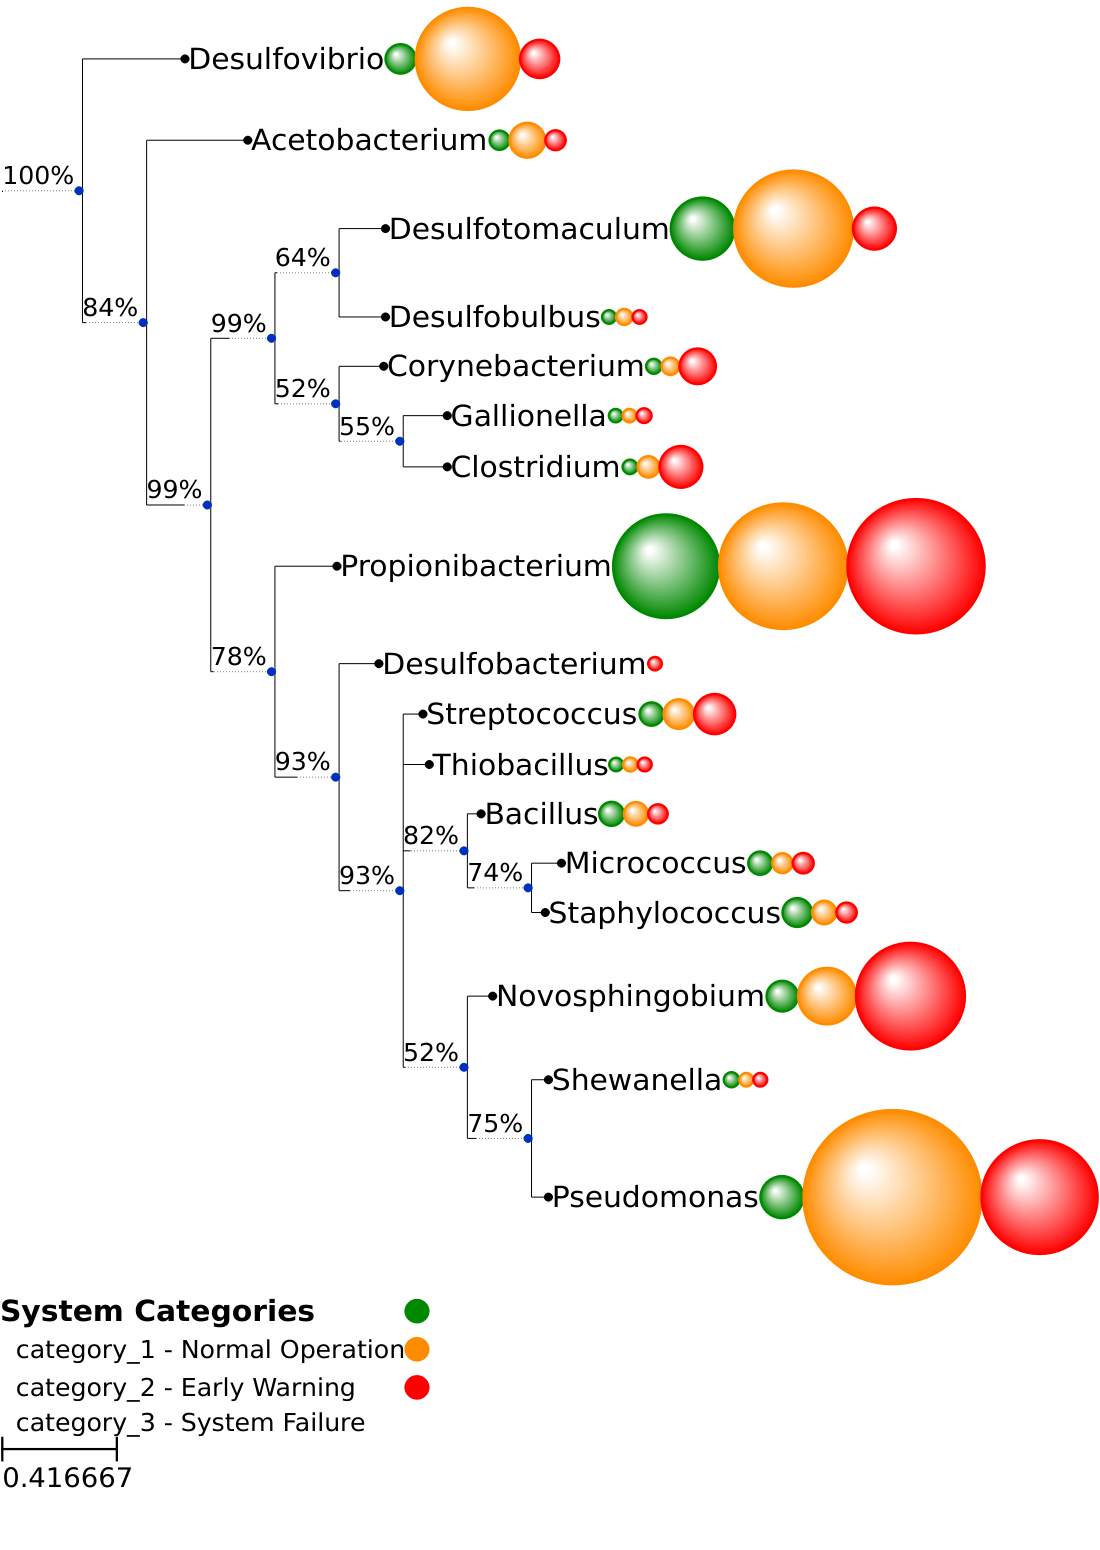 
### Phylogenetic Tree of checked_taxa using MUSCLE

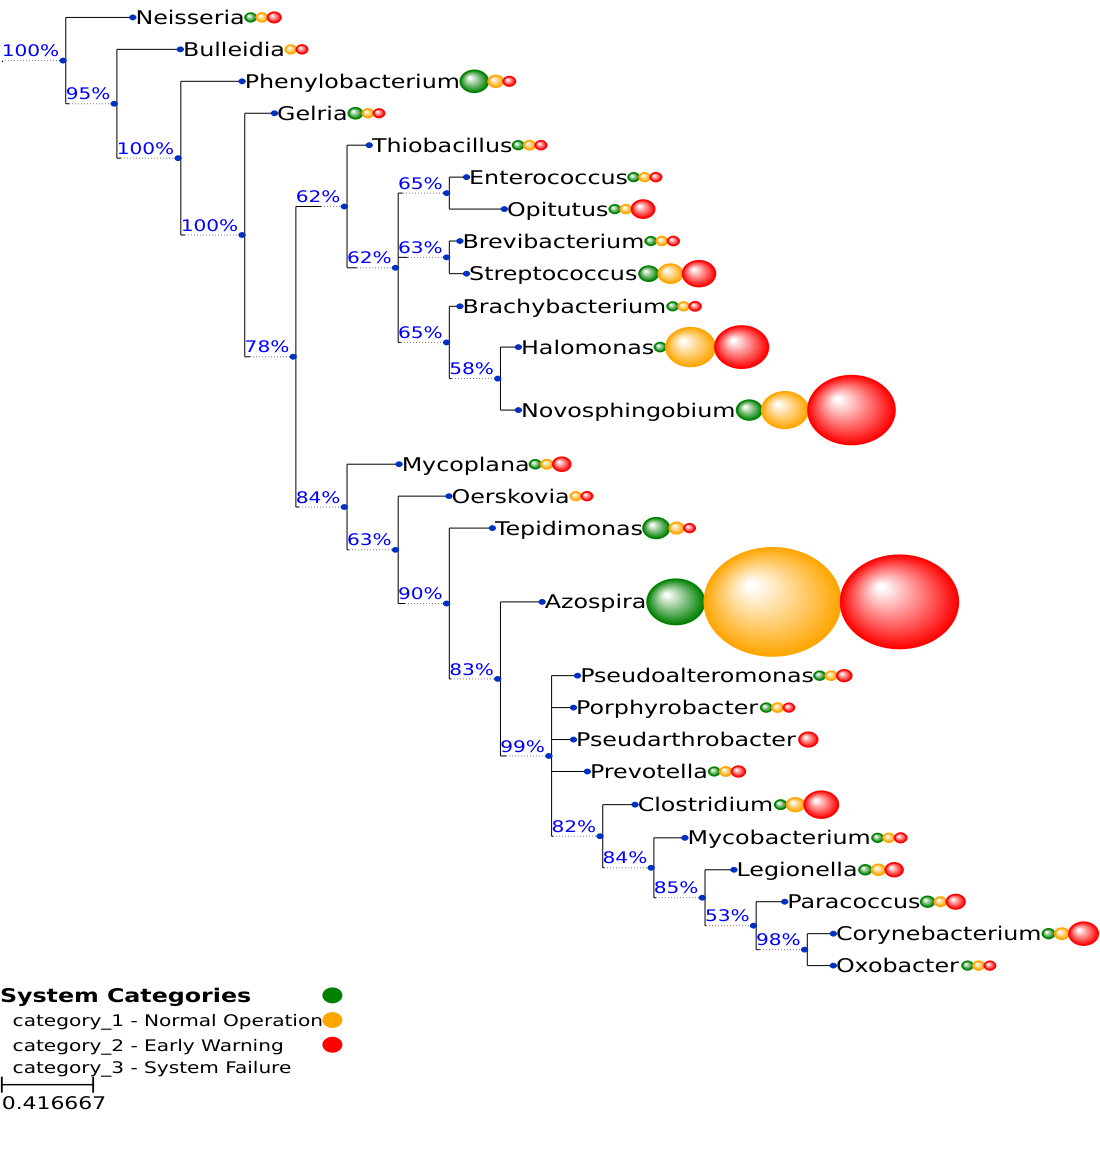

#### Phylogenetic Tree for core_taxa using MUSCLE

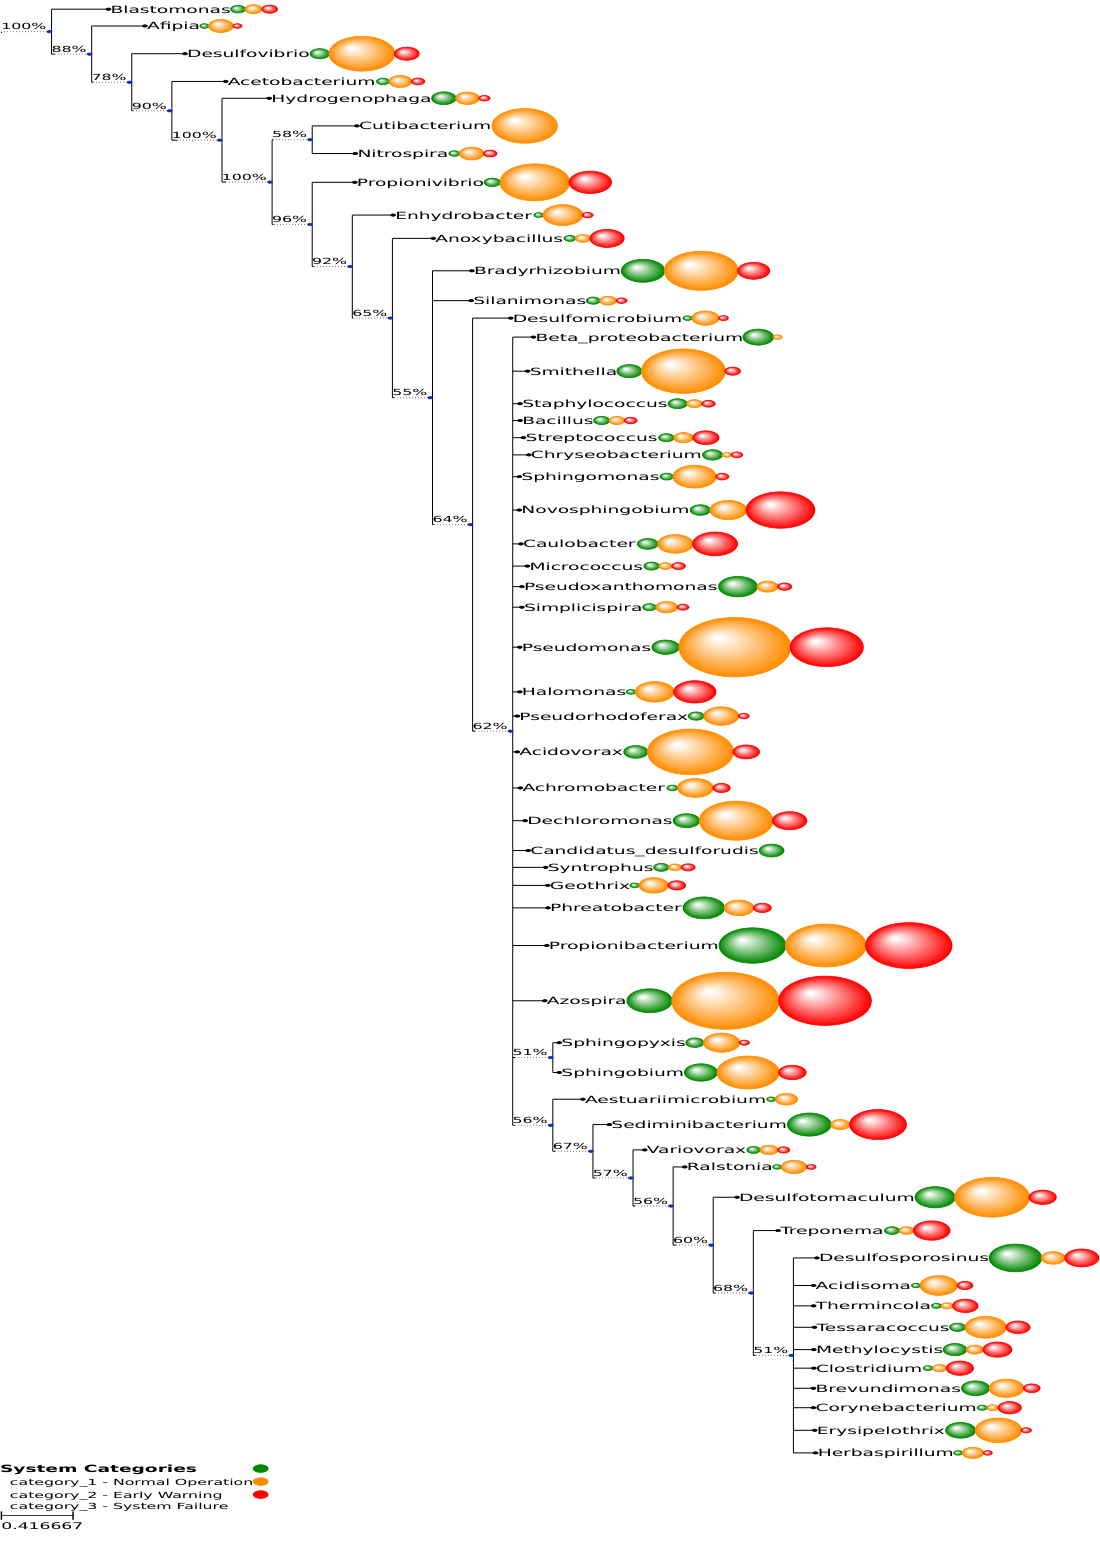

### Phylogenetic Tree for check_core_usual_taxa using MUSCLE
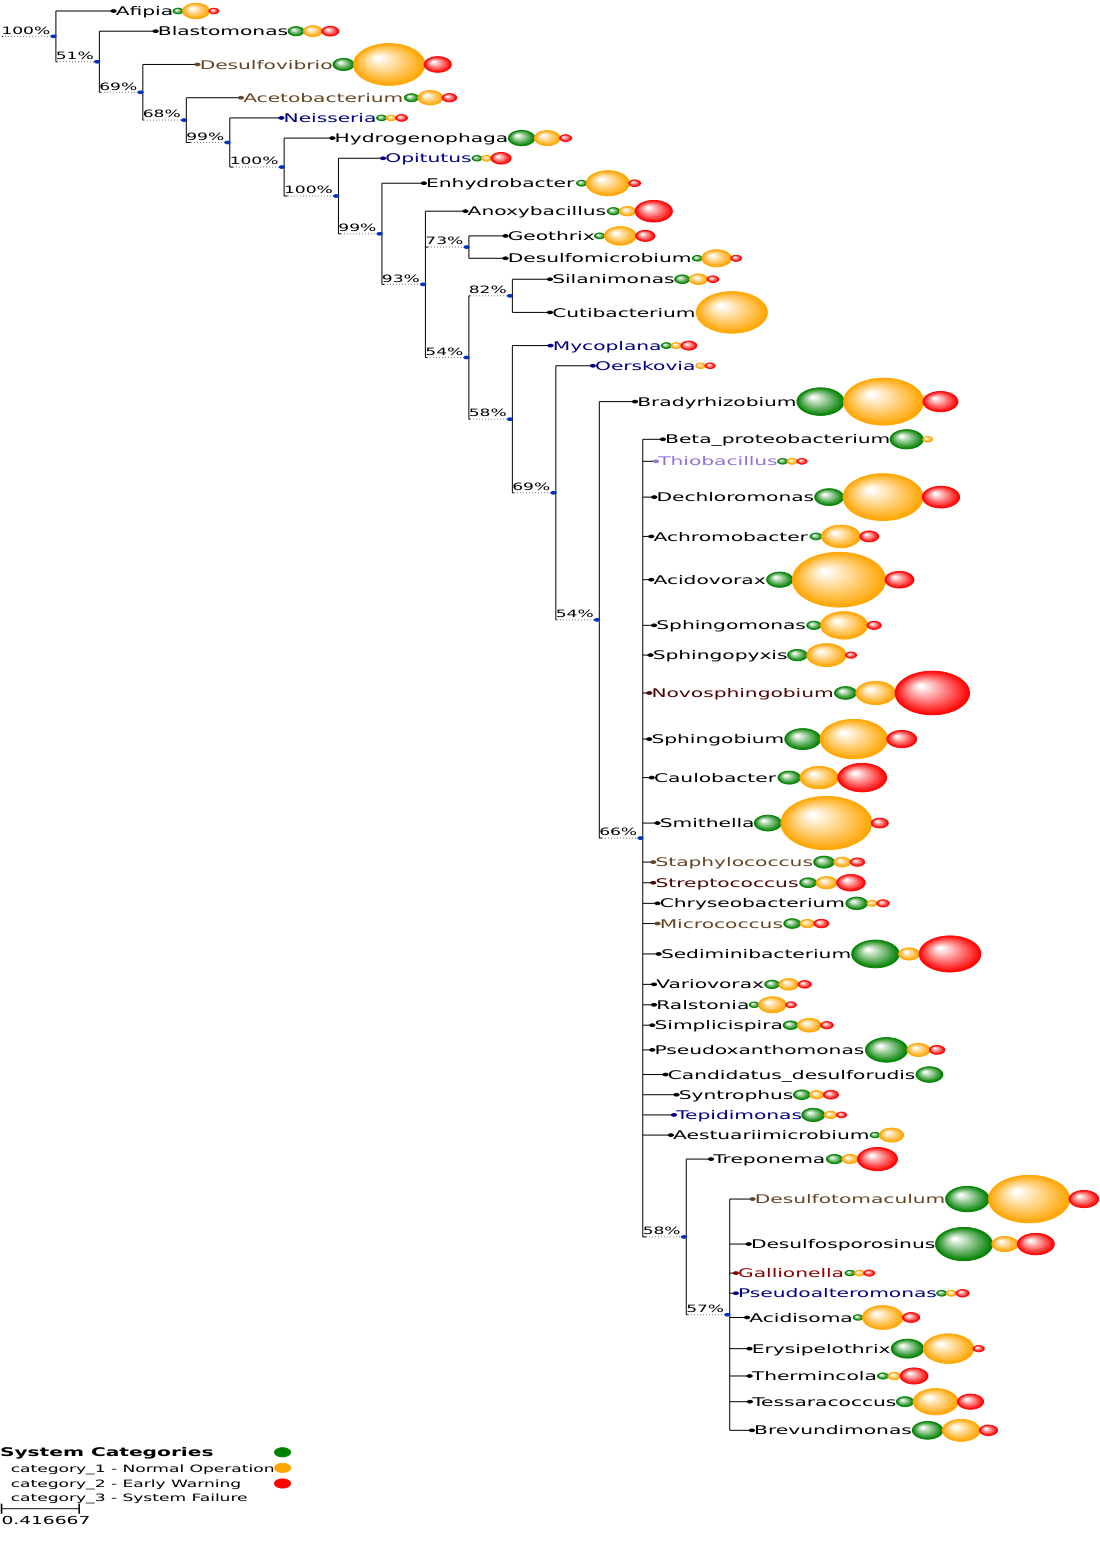
### Phylogenetic Tree for check_core_usual_taxa using QIIME2
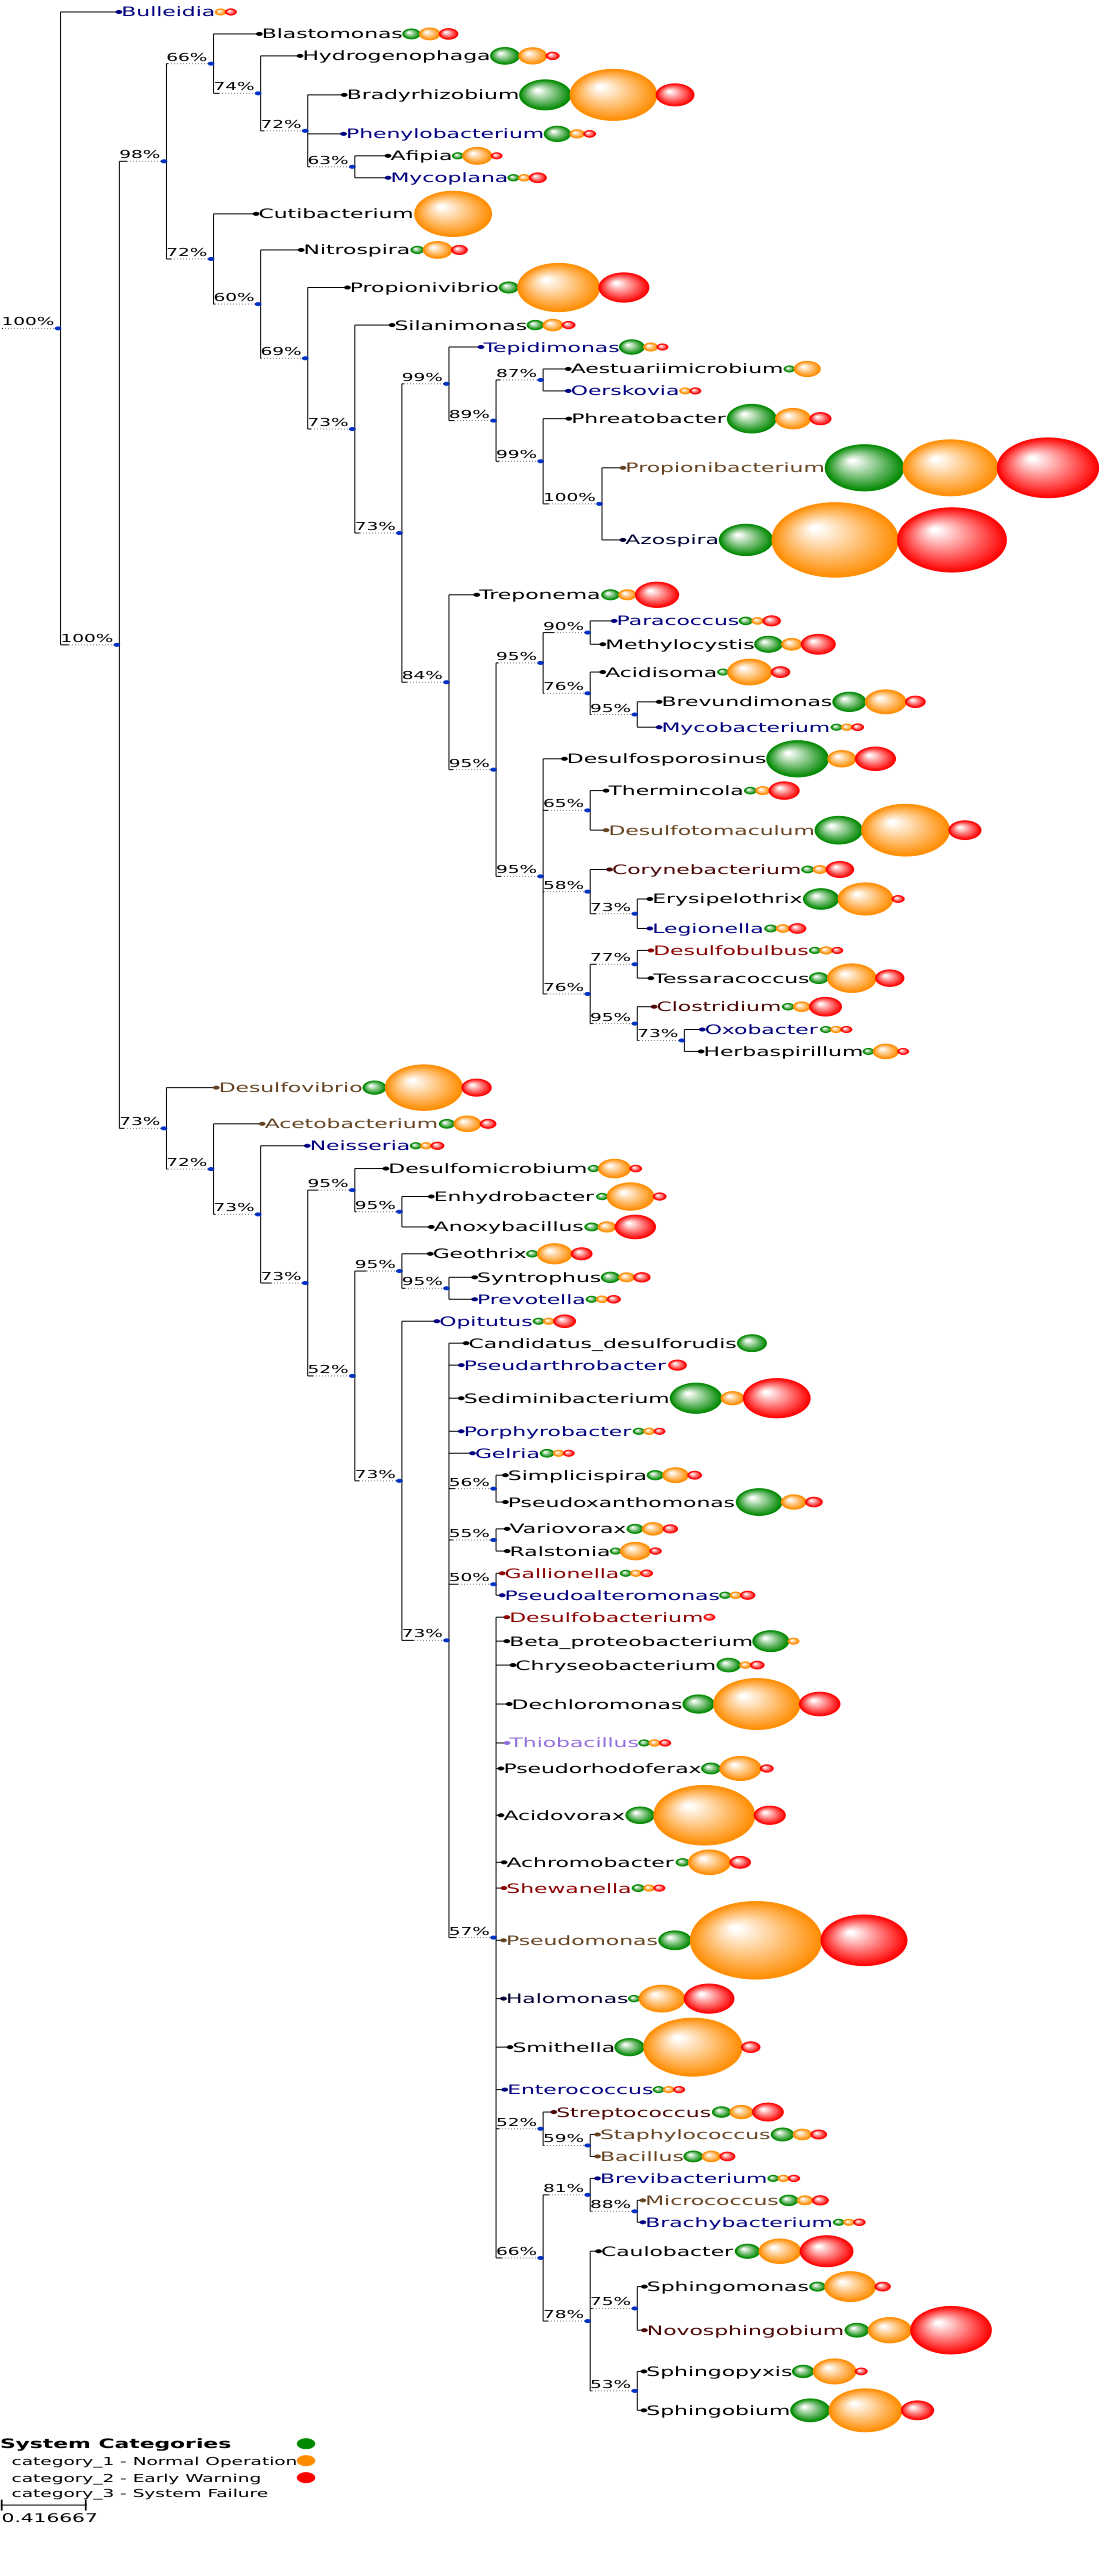


Comparing between the trees made A aligned with Muscle. B made with MAFF alignment through QUIMME2 with agressive masking using DADA . no seeing on this pictures but on the main document. Tree B MAFF alignment only trimming. C made with MAFFT alignment through QIIME2 on trimmed sequences.
All these trees correspond to the integrated data Tree A aligned with MUSCLE show a ladder like structure with less balance evolutionary relationships. 
Tree B Applied aggressive masking parameters where first mask: gap_frequency=0.8, conservation=0.3 and final mask: gap_frequency=0.5, conservation=0.4. It shows an improvement to more balanced hierarchical relationships but too compresed by masking and compared to just the trimming tree C a more ladder-like structure, less balanced evolutionary relationships.Tree C aligned with MAFF only trimming (where only 6 sequences were trimmed to 1700bp but all 79 genera were retained, min_length=500bp, max_length=1700bp) appears to be more balanced amongst the tree, showing more natureal branch lengths, with bootstrap support more balanced 50-100%. Clearer hierarchical clustering, with good resolution for the deeper clades. The abundance patters are more distributed and interpretable.

### Summary of Phylogenetic Analysis for PICRUSt Preparation for MAFF aligned just trimmed consensus tree

The phylogenetic analysis revealed several key patterns that will be important for functional prediction using PICRUSt:

1. **Evolutionary Groups**
- Clustering between traditional corrosion-associated bacteria and newly identified genera. Oxobacteria place itself as a desendent of the Clostridum branch, which suggest shared metabolic capabilities. Oerskovia is an evolutionary ancester of Propionibacterium, which suggest the latest as niche adaptation. Micoplana has no clear relationship and it is a branch where we found phenylobacterium which present an inverse relationship with the risk label and we have propose to be a pioner specie in corrosion systems or have a protective/competitive role on the system. Indeed one of the ancesters Hydrogenophage is presents similar behaviour.  Bulleidia the last of the candidates appears to be very different as all the others finding itself on a completely different branch, which makes it very interesting feature since there is no presence of it on normal systems, this suggest it could be a specialised opportunist.
High bootstrap support (100-73%) for deep branches, indicating reliable evolutionary relationships. The deep branching pattern between aerobin and anaerobic organism suggest multiple independent evolution events of corrosion related traits. This clear metabolic evolution pattern from anaerobic to aerobic organisms, for instance anaerobic organisms such as Desulfovibrio, Desulfobulbus, Desulfotomaculum (sulfate-reducing bacteria), Clostridium (obligate anaerobe),Propionibacterium (facultative anaerobe) to aerobic organisms such as Novosphingobium (strictly aerobic), Legionella (strictly aerobic), Pseudomonas (obligate aerobe), Hydrogenophaga (aerobic), Corynebacterium (aerobic to facultative anaerobic). Desulfovibrio as ancester on its branch, shows a very clear patter of a pioneer species which has dominance as corrosion starts Category 2, but get outcompeted as the systems deteriorate Category 3. 

2. **Functional Patterns**
Sulfate-reducing bacteria (like Desulfovibrio) show pioneer species behavior, declining in category 3 environments. Novosphingobium which functional mechanim is recognised to be strictly aerobic metabolism presents itself as a good marker for these systems since is on high abundance and frequency and has a clear increasing abundance with the risk label. Novosphingobium can breaking down complex organic pollutants, producing extracellular polymeric substances (EPS) which form biofilm, additionally is metal tolerant, bio-transform it. The clustering of Novosphingobium with other high-abundance species suggests co-evolution of traits beneficial in deteriorating systems. Also Legionella as a aerobic-mechanims bacteria show similar patterns as Corynobacterium and are on closer branches, their presence in later stages of corrosion makes sense as oxygen becomes more available due to biofilm development and system deterioration. Biofilm-forming bacteria (Streptococcus, Corynebacterium, Clostridium) cluster together. Novel protective associations discovered (e.g., Phenylobacterium, Hydrogenophaga) potentially due to aromatic compound metabolism outcompeting organometalic transformations? suggesting their protective role might be an ancestral trait.

3. **Community Succession**
Clear ecological succession from early colonizers to late-stage communities is shown and the bootstrap values support the reliability of these succession patterns. Some bacteria appears to have a conflicting pattern being recognised usual corrosive influencing bacteria, however showing bigger presence on category 1 this is the case of Micrococcus, Bacillus, Staphylococcus and Shewanella. The contradictory behavior of known corrosion-influencing bacteria (Micrococcus, Bacillus, etc.) might indicate system-specific roles. Other usual bacteria do no show special pattern on this systems such as Gallionella. Some genera maintain presence across categories but with shifting abundances.Temperature-tolerant and halotolerant bacteria form distinct clusters

4. **Key Findings for PICRUSt**
Mixed clades of known and novel corrosion-associated bacteria suggest shared metabolic capabilities. Also there is evidence of potential shifting meachanisms due to system degradation and a consequent environmental adaptation on the bacteria that has bigger presence on Category 2 right?. The nobel candidates show strong bootstrap support, which validates their inclusion in functional analysis.

This phylogenetic foundation suggests that PICRUSt analysis should focus on- Metabolic pathways shared between traditional and newly identified corrosion-associated bacteria. Veryfy the assumptions of the analysis, get deeper understanding of functional transitions between succession stages
Compare metabolic potential between pioneer species and late-stage colonizers. Understand the protective metabolic capabilities in inverse-relationship genera by analysing shared pathways between for instance Phenylobacterium-Hydrogenophaga clade members. Maybe will be good idea to trimm out the usual genera that  behave on a contradictory way? : Micrococcus, Bacillus, Staphylococcus and Shewanella. Or focus on comparing metabolic pathways between contradictory behavior species and consistent behavior species. Investigate metabolic capabilities of the unique Bulleidia branch

In [ ]:
'''from ete3 import Tree, TextFace

# Load the tree
t = Tree("data/consensus_tree.newick", format=0) 

# Metabolic data 
metabolic_data = {
          'Clostridium': 'Pathway_Z',
      'Corynebacterium': 'Pathway_A',
               'Gelria': 'Pathway_B',
          'Haemophilus': 'Pathway_C',
            'Halomonas': 'Pathway_D',
           'Legionella': 'Pathway_E',
            'Oerskovia': 'Pathway_F',
            'Oxobacter': 'Pathway_G',
        'Porphyromonas': 'Pathway_H',
              'Psb-m-3': 'Pathway_I',
    'Pseudarthrobacter': 'Pathway_J',
    'Pseudoalteromonas': 'Pathway_K',
          'Rhodobacter': 'Pathway_L',
           'Roseateles': 'Pathway_M',
            'Roseococc': 'Pathway_N'
}

# Annotate the tree
for leaf in t.iter_leaves():
    if leaf.name in metabolic_data:
        metabolic_info = TextFace(metabolic_data[leaf.name])
        leaf.add_face(metabolic_info, column=1, position="branch-right")

# Show or render the tree
t.show()
# Render the tree
#t.render("%%inline", w=800, units="px", tree_style=ts)'''

'from ete3 import Tree, TextFace\n\n# Load the tree\nt = Tree("data/consensus_tree.newick", format=0) \n\n# Metabolic data \nmetabolic_data = {\n          \'Clostridium\': \'Pathway_Z\',\n      \'Corynebacterium\': \'Pathway_A\',\n               \'Gelria\': \'Pathway_B\',\n          \'Haemophilus\': \'Pathway_C\',\n            \'Halomonas\': \'Pathway_D\',\n           \'Legionella\': \'Pathway_E\',\n            \'Oerskovia\': \'Pathway_F\',\n            \'Oxobacter\': \'Pathway_G\',\n        \'Porphyromonas\': \'Pathway_H\',\n              \'Psb-m-3\': \'Pathway_I\',\n    \'Pseudarthrobacter\': \'Pathway_J\',\n    \'Pseudoalteromonas\': \'Pathway_K\',\n          \'Rhodobacter\': \'Pathway_L\',\n           \'Roseateles\': \'Pathway_M\',\n            \'Roseococc\': \'Pathway_N\'\n}\n\n# Annotate the tree\nfor leaf in t.iter_leaves():\n    if leaf.name in metabolic_data:\n        metabolic_info = TextFace(metabolic_data[leaf.name])\n        leaf.add_face(metabolic_info, column=1, position

## 6.7. Missing Bacteria
Different searchs have been unsuscessfull retrieving the total of the bacteria sequences, with a failing percentage of 50-95%. In the last search there were some missing bacteria, therefore the idea is to append them to the accension_taxa dataframe so that we can plot the missings ones.

In [ ]:
'''# 1. First load the dataframes and verify they loaded correctly
all_taxa = pd.read_excel('~/MIC/2_Micro/data_Ref/merged_to_sequence.xlsx',
                        sheet_name='core_check_usual_taxa',
                        header=[0,1,2,3,4,5,6,7])
print("all_taxa loaded:", type(all_taxa))

accession = pd.read_csv('data_tree/taxa_accension.csv')
print("accession loaded:", type(accession))

# 2. Check the structure of each dataframe
print("\nall_taxa columns:")
print(all_taxa.columns.get_level_values(6))

print("\naccession columns:")
print(accession.columns.tolist())

# 3. Now try the comparison
all_taxa_g = set(all_taxa.columns.get_level_values(6))
accession_g = set(accession['Genus'])  # Make sure 'Genus' is actually a column name
missing_genera = all_taxa_g - accession_g

print("\nMissing genera:")
for genus in sorted(missing_genera):
    print(f"- {genus}")'''

'# 1. First load the dataframes and verify they loaded correctly\nall_taxa = pd.read_excel(\'~/MIC/2_Micro/data_Ref/merged_to_sequence.xlsx\',\n                        sheet_name=\'core_check_usual_taxa\',\n                        header=[0,1,2,3,4,5,6,7])\nprint("all_taxa loaded:", type(all_taxa))\n\naccession = pd.read_csv(\'data_tree/taxa_accension.csv\')\nprint("accession loaded:", type(accession))\n\n# 2. Check the structure of each dataframe\nprint("\nall_taxa columns:")\nprint(all_taxa.columns.get_level_values(6))\n\nprint("\naccession columns:")\nprint(accession.columns.tolist())\n\n# 3. Now try the comparison\nall_taxa_g = set(all_taxa.columns.get_level_values(6))\naccession_g = set(accession[\'Genus\'])  # Make sure \'Genus\' is actually a column name\nmissing_genera = all_taxa_g - accession_g\n\nprint("\nMissing genera:")\nfor genus in sorted(missing_genera):\n    print(f"- {genus}")'

Missing genera:
- Clostridium_sensu_stricto_12
- Oxalobacteraceae_unclassified
- Psb-m-3
- Ruminiclostridium_1
- Unnamed: 0_level_6
- Unnamed: 1_level_6
- Unnamed: 2_level_6
- Wchb1-05

In [ ]:
'''# Comunicating with the NCBI
from config import NCBI_API_KEY, NCBI_EMAIL

Entrez.email= "wattsbeatrizamanda@gmail.com" #
Entrez.api_key  = "01d2f369faef0e78cd4906063672fab7c809"


logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
'''

'# Comunicating with the NCBI\nfrom config import NCBI_API_KEY, NCBI_EMAIL\n\nEntrez.email= "wattsbeatrizamanda@gmail.com" #\nEntrez.api_key  = "01d2f369faef0e78cd4906063672fab7c809"\n\n\nlogging.basicConfig(\n    level=logging.INFO,\n    format=\'%(asctime)s - %(levelname)s - %(message)s\'\n)\n'

In [ ]:
'''def search_sequences(genus, entrez, max_retries=5, base_delay=30, max_delay=120):
    """
    Search for sequences with improved error handling and validation.
    """
    if not isinstance(genus, str) or not genus.strip():
        raise ValueError("Genus must be a non-empty string")
    if not hasattr(entrez, 'email') or not entrez.email:
        raise RuntimeError("Entrez email configuration missing")
    
    retry_count = 0
    delay = base_delay

    while retry_count < max_retries:
        try:
            search_term = (f"{genus}[Organism] AND "
                         "(16S[All Fields] OR 16S ribosomal RNA[All Fields] OR "
                         "16S rRNA[All Fields]) AND "
                         "500:2000[Sequence Length]")
            
            logging.info(f"Attempting search for {genus} (attempt {retry_count + 1}/{max_retries})")
            # Search NCBI database
            handle = entrez.esearch(db="nucleotide", term=search_term, retmax=100)
            
            try:
                record = entrez.read(handle)
                time.sleep(5)
            except entrez.Parser.ValidationError as ve:
                logging.error(f"NCBI validation error for {genus}: {str(ve)}")
                retry_count += 1
                continue
            finally:
                handle.close()
            
            sequence_count = len(record.get('IdList', []))
            logging.info(f"Found {sequence_count} sequences for {genus}")
            
            if sequence_count > 0:
                return record['IdList']
            
            logging.warning(f"No sequences found for {genus}")
            return []
            
        except Exception as e:
            logging.error(f"Error in search for {genus}: {str(e)}")
            
        retry_count += 1
        if retry_count < max_retries:
            wait_time = min(delay * (2 ** retry_count), max_delay)
            logging.info(f"Waiting {wait_time} seconds before retry...")
            time.sleep(wait_time)
    
    return []'''

'def search_sequences(genus, entrez, max_retries=5, base_delay=30, max_delay=120):\n    """\n    Search for sequences with improved error handling and validation.\n    """\n    if not isinstance(genus, str) or not genus.strip():\n        raise ValueError("Genus must be a non-empty string")\n    if not hasattr(entrez, \'email\') or not entrez.email:\n        raise RuntimeError("Entrez email configuration missing")\n    \n    retry_count = 0\n    delay = base_delay\n\n    while retry_count < max_retries:\n        try:\n            search_term = (f"{genus}[Organism] AND "\n                         "(16S[All Fields] OR 16S ribosomal RNA[All Fields] OR "\n                         "16S rRNA[All Fields]) AND "\n                         "500:2000[Sequence Length]")\n            \n            logging.info(f"Attempting search for {genus} (attempt {retry_count + 1}/{max_retries})")\n            # Search NCBI database\n            handle = entrez.esearch(db="nucleotide", term=search_term, retmax=1

In [ ]:
'''def append_missing_genera():
    
    # Read existing results
    existing_df = pd.read_csv('data_tree/taxa_accension.csv')
    
    # Search only for missing bacteria
    additional_results = {}
    for bacteria in missing_genera:
        print(f"Searching for {bacteria}...")
        result = search_sequences(bacteria, Entrez)
        if result:
            additional_results[bacteria] = result
            print(f"Found sequences for {bacteria}")
        else:
            print(f"No sequences found for {bacteria}")
        time.sleep(30)  # Being nice to NCBI
            
    # Create DataFrame for new sequences
    new_sequences = pd.DataFrame(list(additional_results.items()), 
                               columns=['Genus', 'IDs'])
    
    # Save new sequences separately
    new_sequences.to_csv('data_tree/additional_sequences.csv')
    
    # Combine for further processing
    combined_df = pd.concat([existing_df, new_sequences], ignore_index=True)
    combined_df.to_csv('data_tree/combined_taxa_accension.csv')
    
    return combined_df'''

'def append_missing_genera():\n    \n    # Read existing results\n    existing_df = pd.read_csv(\'data_tree/taxa_accension.csv\')\n    \n    # Search only for missing bacteria\n    additional_results = {}\n    for bacteria in missing_genera:\n        print(f"Searching for {bacteria}...")\n        result = search_sequences(bacteria, Entrez)\n        if result:\n            additional_results[bacteria] = result\n            print(f"Found sequences for {bacteria}")\n        else:\n            print(f"No sequences found for {bacteria}")\n        time.sleep(30)  # Being nice to NCBI\n            \n    # Create DataFrame for new sequences\n    new_sequences = pd.DataFrame(list(additional_results.items()), \n                               columns=[\'Genus\', \'IDs\'])\n    \n    # Save new sequences separately\n    new_sequences.to_csv(\'data_tree/additional_sequences.csv\')\n    \n    # Combine for further processing\n    combined_df = pd.concat([existing_df, new_sequences], ignore_index=Tru

In [ ]:
'''# Search just the missing genera
missing_genera = [
    "Clostridium_sensu_stricto_12",
    "Oxalobacteraceae_unclassified",
    "Psb-m-3", 
    "Ruminiclostridium", #_1
    "Wchb1-05"
]
results_missing = {}
for bacteria in missing_genera:
    print(f"Searching for {bacteria}...")
    result = search_sequences(bacteria, Entrez)  # Keep this as result
    if result:
        results_missing[bacteria] = result    # Store in results_missing
        print(f"Found sequences for {bacteria}")
    time.sleep(30)  # Being nice to NCBI'''

'# Search just the missing genera\nmissing_genera = [\n    "Clostridium_sensu_stricto_12",\n    "Oxalobacteraceae_unclassified",\n    "Psb-m-3", \n    "Ruminiclostridium", #_1\n    "Wchb1-05"\n]\nresults_missing = {}\nfor bacteria in missing_genera:\n    print(f"Searching for {bacteria}...")\n    result = search_sequences(bacteria, Entrez)  # Keep this as result\n    if result:\n        results_missing[bacteria] = result    # Store in results_missing\n        print(f"Found sequences for {bacteria}")\n    time.sleep(30)  # Being nice to NCBI'

In [ ]:
'''# Create DataFrame for new sequences
new_sequences = pd.DataFrame(list(results_missing.items()), columns=['Genus', 'IDs'])

# Read existing file
existing_df = pd.read_csv('data_tree/taxa_accension.csv')

# Combine old and new
combined_df = pd.concat([existing_df, new_sequences], ignore_index=True)

# Save with new name to be safe
combined_df.to_csv('data_tree/taxa_accension_complete.csv', index=False)'''

"# Create DataFrame for new sequences\nnew_sequences = pd.DataFrame(list(results_missing.items()), columns=['Genus', 'IDs'])\n\n# Read existing file\nexisting_df = pd.read_csv('data_tree/taxa_accension.csv')\n\n# Combine old and new\ncombined_df = pd.concat([existing_df, new_sequences], ignore_index=True)\n\n# Save with new name to be safe\ncombined_df.to_csv('data_tree/taxa_accension_complete.csv', index=False)"

# 7. Retrieving Sequences from the Greenes Gene DataBase
## 7.1. Analysing the whole Data to biom statistics

In [ ]:
# droping source and genus and putting GID as index
pre_biom= Integrated.drop(columns=["Source", "GID"])
pre_biom= pre_biom.set_index("Genus")

Having the cleaned structure for Biom transformation, follows the formatting
__Formatting Integrated df whole data to Biom table to QIIME artifact__
It creates a table with GID/OTUS as index, Sites as headers, abundance values and saves it as abundance.biom

In [ ]:
# Create BIOM table
biom_table = Table(
    data= pre_biom.values,
    observation_ids=pre_biom.index.astype(str),  # GID strings
    sample_ids=pre_biom.columns.astype(str) ,  # Sites as sample IDs
)

# Write to file
output_biom = "/home/beatriz/MIC/2_Micro/data_qiime/abundance_84.biom"
with biom_open(output_biom, 'w') as f:
    biom_table.to_hdf5(f, "Abundance data in BIOM format")

# Verify BIOM file
print(f"BIOM file created: {output_biom}")
print(f"Number of observations: {biom_table.shape[0]}")
print(f"Number of samples: {biom_table.shape[1]}")

# Convert BIOM to QIIME2 artifact
table_artifact = qiime2.Artifact.import_data(
    'FeatureTable[Frequency]',
    output_biom
)
# Verify QIIME2 artifact
print("\nQIIME2 Artifact Info:")
print(f"Type: {table_artifact.type}")
print(f"UUID: {table_artifact.uuid}")

biom_table = load_table("/home/beatriz/MIC/2_Micro/data_qiime/abundance_84.biom")
print(biom_table)

BIOM file created: /home/beatriz/MIC/2_Micro/data_qiime/abundance_84.biom
Number of observations: 85
Number of samples: 70

QIIME2 Artifact Info:
Type: FeatureTable[Frequency]
UUID: aec71a2c-5dd7-4a2e-9cde-5d08a6b5b2ee


In [ ]:
biom_table = load_table("/home/beatriz/MIC/2_Micro/data_qiime/abundance_84.biom")
print(biom_table)

# Constructed from biom file
#OTU ID	site_1	site_2	site_3	site_4	site_5	site_6	site_7	site_8	site_9	site_10	site_11	site_12	site_13	site_14	site_15	site_16	site_17	site_18	site_19	site_20	site_21	site_22	site_23	site_24	site_25	site_26	site_27	site_28	site_29	site_30	site_31	site_32	site_33	site_34	site_35	site_36	site_37	site_38	site_39	site_40	site_41	site_42	site_43	site_44	site_45	site_46	site_47	site_48	site_49	site_50	site_51	site_52	site_53	site_54	site_55	site_56	site_57	site_58	site_59	site_60	site_61	site_62	site_63	site_64	site_65	site_66	site_67	site_68	site_69	site_70
Azospira	26.92804825506247	1.859229747675963	3.093542843113184	2.573991229036737	2.709368672924719	0.0	2.14623499454347	0.54	3.903179707038228	0.0	0.1023279611153748	3.245378498399257	0.5160778086542279	0.1007895178901394	0.07216395650918889	0.9942834807250697	0.3176283748014823	2.252422297722411	0.0	32.25946258306848	36.44453233142179	0.1172691582113904	0.08991276032174188	1.037941994437823	5.197792088316467

In [ ]:

!biom summarize-table -i /home/beatriz/MIC/2_Micro/data_qiime/abundance_84.biom

Num samples: 70
Num observations: 85
Total count: 5674
Table density (fraction of non-zero values): 0.405

Counts/sample summary:
 Min: 18.180
 Max: 99.058
 Median: 85.108
 Mean: 81.069
 Std. dev.: 15.788
 Sample Metadata Categories: None provided
 Observation Metadata Categories: None provided

Counts/sample detail:
site_69: 18.180
site_67: 21.790
site_70: 27.060
site_26: 58.300
site_21: 58.973
site_5: 60.650
site_4: 63.726
site_56: 65.858
site_32: 66.861
site_28: 69.038
site_46: 71.158
site_61: 71.365
site_6: 72.140
site_68: 72.985
site_3: 73.103
site_9: 73.836
site_1: 74.278
site_38: 74.883
site_36: 77.693
site_10: 77.890
site_58: 78.578
site_22: 79.503
site_2: 79.852
site_33: 79.930
site_13: 80.151
site_34: 81.040
site_63: 81.345
site_59: 81.498
site_30: 81.929
site_62: 82.900
site_52: 83.379
site_29: 83.535
site_15: 83.994
site_18: 84.812
site_57: 85.073
site_45: 85.143
site_8: 85.540
site_35: 85.809
site_25: 86.471
site_12: 87.016
site_51: 88.327
site_64: 88.510
site_19: 88.784
s

 __Whole data analysis__
Sumarising the counts of the samples (Sites) and the observations (genera) in the previous cell. This represent statistics, include values like min and max mean and median counts per sample. The raw data provided by the studied as mencioned everywhere else represents relative abundances. The samples (~98%) are normalized so that their total abundance sums to 99-100%, as expected for datasets providing relative abundances. 70 samples are to 100-99% abundance relative percentage. 10 of them are less than 99%. Two of them are 89 and 87% this diferences could be due to normalisation artifacts, rounding or truncation. Also if the technicians filtered out rare or low-abundance taxa to clean the dataset, those exclusions may account for totals less than 100%. Samples with higher proportions of these filtered taxa might show a bigger drop. This is for the raw percentages, Now the biom statistics reflex other view of the data, the following statistics were done for the whole 84 features/observations/genera:

Num samples: 70
Num observations: 84
Total count: 5630
Table density (fraction of non-zero values): 0.406

Counts/sample summary:
 Min: 18.180
 Max: 99.058
 Median: 84.819
 Mean: 80.439
 Std. dev.: 16.000
 Sample Metadata Categories: None provided
 Observation Metadata Categories: None provided

Counts/sample detail:
site_69: 18.180
site_67: 21.790
site_70: 27.060
site_13: 54.982
site_26: 58.300
site_21: 58.973
site_5: 60.650

The Statistics seen in this biom table could be read as low intensity (0.406) and indicates that more than half the taxa have zero counts for most samples, consistent with a dataset dominated by a few taxa. Counts/sample summary is calculated by relative abundances and site_69 shows very low count, that maybe explained by an uneven distribution of taxa (highly skewed abundances, few dominant taxa or/and technical issues during sample preparation or sequencing). Other possible explanations for the low density of the samples 69,67,70 could be that they are the very sites with missing taxa and it is noticed during the evaluation of the sequences. However close inspection of the sites: site_40 has 77% of sequences been removed by concept of removing Clostridium_sensu_stricto_12, because the sequence was no get from the NCBI nor elsewhere and however this site shows a count ratio of 91.21 %. Same site when removed these missing genera from the data, shows a very low relative abundance which is expected since 73% was removed by no sequenciating the Clostridium sensu stricto 12. Site_31 has a percentage of 55,35 of Oxalobacteraceae_unclassified which has been also removed. Sites 12,38 and 65, has been remove between 8-14% by concept of removing Psb-m-3 bacteria.  Sites 20 and 41 has been removed between 11-18% sequences when removing Ruminiclostridium_1 bacteria. Site 12 has removed Wchb1-0 bacteria which accounted for 20% of the abundance of the site. However the fact that this removals are not being reflected on the statistical summary is a good signal that those genera were no relevant for the community as they do not belong to any of the here studied groups of genera core_taxa, checked_genera or usual_taxa. Instead the percentages are reflecting that on site_69, there is few of our selected genera and hence the representation is very low. In conclusion sites site_69, site_67 and site_70 have different community compositions than the others, with fewer of the target bacteria present, which is no a surprise since those sites come from UK sites.

## 7.2. Formatting Integrated df from Retrieved Genera from the NCBI to Biom table to QIIME artifact
Some bacterial genera were excluded from the analysis due to unavailable reference sequences, primarily affecting rare species. The following genera were removed: Clostridium_sensu_stricto_12, Oxalobacteraceae_unclassified, Psb-m-3, Ruminiclostridium_1, and Wchb1-05. As demonstrated in Section 2.3, the statistical analysis of the BIOM-formatted data confirmed that the removal of these genera did not significantly impact the overall results of this study.

In [ ]:
# List of genera to remove
genera_to_remove = {'Clostridium_sensu_stricto_12', 'Oxalobacteraceae_unclassified', 
                   'Psb-m-3', 'Ruminiclostridium_1', 'Wchb1-05'}

# Filter out the rows where Genus column matches any of the genera in the list


Integrated_79= Integrated [~Integrated ['Genus'].isin(genera_to_remove)]

In [ ]:
# droping source and genus and putting GID as index
pre_biom_79= Integrated_79.drop(columns=["Source", "GID"])
pre_biom_79= pre_biom_79.set_index("Genus")

In [ ]:
# Create BIOM table
biom_table = Table(
    data= pre_biom_79.values,
    observation_ids=pre_biom_79.index.astype(str),  # GID strings
    sample_ids=pre_biom_79.columns.astype(str) ,  # Sites as sample IDs
)

# Write to file
output_biom = "/home/beatriz/MIC/2_Micro/data_qiime/abundance_79.biom"
with biom_open(output_biom, 'w') as f:
    biom_table.to_hdf5(f, "Abundance data in BIOM format")

# Verify BIOM file
print(f"BIOM file created: {output_biom}")
print(f"Number of observations: {biom_table.shape[0]}")
print(f"Number of samples: {biom_table.shape[1]}")

# Convert BIOM to QIIME2 artifact
table_artifact = qiime2.Artifact.import_data(
    'FeatureTable[Frequency]',
    output_biom
)
# Verify QIIME2 artifact
print("\nQIIME2 Artifact Info:")
print(f"Type: {table_artifact.type}")
print(f"UUID: {table_artifact.uuid}")

BIOM file created: /home/beatriz/MIC/2_Micro/data_qiime/abundance_79.biom
Number of observations: 80
Number of samples: 70

QIIME2 Artifact Info:
Type: FeatureTable[Frequency]
UUID: f6107cc1-151e-4065-95de-f589fa6db8e4


In [ ]:
biom_table = load_table("/home/beatriz/MIC/2_Micro/data_qiime/abundance_79.biom")
# print(biom_table)
!biom summarize-table -i /home/beatriz/MIC/2_Micro/data_qiime/abundance_79.biom

Num samples: 70
Num observations: 80
Total count: 5422
Table density (fraction of non-zero values): 0.415

Counts/sample summary:
 Min: 13.533
 Max: 99.058
 Median: 81.400
 Mean: 77.464
 Std. dev.: 18.127
 Sample Metadata Categories: None provided
 Observation Metadata Categories: None provided

Counts/sample detail:
site_40: 13.533
site_69: 18.180
site_67: 21.790
site_70: 27.060
site_31: 38.678
site_12: 55.386
site_26: 58.299
site_21: 58.475
site_5: 60.650
site_56: 63.038
site_4: 63.722
site_38: 66.783
site_32: 66.851
site_28: 68.983
site_46: 70.416
site_61: 71.346
site_6: 72.140
site_68: 72.985
site_3: 73.103
site_9: 73.809
site_65: 74.034
site_1: 74.257
site_41: 74.918
site_36: 77.672
site_10: 77.890
site_13: 78.007
site_20: 78.012
site_30: 78.382
site_58: 78.559
site_22: 79.098
site_2: 79.852
site_33: 79.902
site_34: 81.040
site_29: 81.136
site_63: 81.322
site_59: 81.477
site_62: 82.878
site_45: 83.109
site_52: 83.376
site_57: 83.547
site_15: 83.768
site_18: 84.799
site_35: 85.368


____Analysis of the implications of removing the features no found on the NCBI search__
There are changes on the data biom by removing the 5 genera no found by the NCBI. Total unique features decreased from 84 to 80 genera. Overall table density improved slightly from 0.406 to 0.415
Mean sample counts decreased from 80.439 to 77.464. Standard deviation increased from 16.0 to 18.127

Site_40 became the lowest abundance site (13.533%) after removing Clostridium_sensu_stricto_12, dropping from ~91%.
Site_31 shows significantly reduced abundance (38.678%) after removing Oxalobacteraceae_unclassified.
Site_12 now at 55.386% after removal of multiple genera including Wchb1-05.

The implications of the removal is the increased standard deviation and lower mean, which suggest the removals exposed more underlying community variation between samples. The minimal change in table density indicates the removed genera were not major contributors to the overall community structure across most samples, supporting the hypothesis that they weren't central to the core, checked, or usual taxa groups. The dramatic impact on specific sites (40, 31, 12) suggests these locations may have unique community compositions worth investigating further.
Therefore I have decided to explore the green genes database instead or in addition to the NCBI data we already have. It could help recover taxonomic information for currently missing genera. It would reduce the impact on sites heavily dominated by currently unmatched taxa providing more standardized taxonomic assignments compatible with downstream analyses.

## 7.3. Alternative Approach by Retrieving the Otus and Sequences Directly from the Greenes DataBase 
The initial NCBI-based sequence retrieval strategy encountered limitations, with several key bacterial genera remaining unidentified. However, preliminary investigation suggests these missing taxa may be represented within the GreenGenes database, offering an opportunity to improve taxonomic coverage. This alternative approach leverages GreenGenes' hierarchical taxonomic structure and its optimization for PICRUSt2 analysis.
The proposed methodology differs fundamentally from the original NCBI approach. Rather than starting with sequence retrieval and subsequent taxonomic assignment, this strategy begins by querying the GreenGenes taxonomy file for matches to our target genera. The multi-level taxonomic information (genus, family, and order) provides a framework for more precise identification, reducing ambiguity when genera names appear across multiple taxonomic lineages. Once matching OTUs are identified in the taxonomy file, their corresponding sequences can be extracted directly from the GreenGenes reference database.
This approach offers several advantages. First, GreenGenes sequences are pre-formatted for PICRUSt2 analysis, eliminating potential compatibility issues. Second, the hierarchical taxonomy search reduces misidentification risk compared to genus-level matching alone. Third, the direct OTU-to-sequence mapping eliminates the need for separate accession number tracking.
The implementation requires modifying the existing taxonomy matching script to incorporate sequence retrieval. The core matching logic using genus, family, and order levels remains valuable, but needs extension to map identified OTUs to their sequences in the GreenGenes fasta file. This provides a more streamlined pipeline while potentially improving the accuracy of both taxonomic assignment and downstream functional predictions.
Given the initial assessment showed sites 40 and 31 were significantly impacted by missing taxa (dropping to 13.533% and 38.678% abundance respectively), this refined approach could help maintain the integrity of community composition analysis across all sampling sites while ensuring compatibility with PICRUSt2's functional prediction framework.

Now I have to isolate the taxa on a dataframe so that the following  script can loop throught it and get access no only to the genus but to the family and order and in this way access the OTUS and posteriorly the sequences located on the fasta greengenes database.

In [ ]:
taxa_df = selected_taxa.iloc[:, :8]
taxa_df = taxa_df[(taxa_df.iloc[:, 0] != "Category")]
taxa_df = taxa_df.reset_index(drop =True)

In [ ]:
print(*taxa_df["Genus"].tolist())

Azospira Brachybacterium Brevibacterium Bulleidia Clostridium Corynebacterium Enterococcus Gelria Halomonas Legionella Mycobacterium Mycoplana Neisseria Novosphingobium Oerskovia Opitutus Oxobacter Paracoccus Phenylobacterium Porphyrobacter Prevotella Psb-m-3 Pseudarthrobacter Pseudoalteromonas Streptococcus Tepidimonas Thiobacillus Acetobacterium Achromobacter Acidisoma Acidovorax Aestuariimicrobium Afipia Anoxybacillus Bacillus Beta_proteobacterium Blastomonas Bradyrhizobium Brevundimonas Candidatus_desulforudis Caulobacter Chryseobacterium Clostridium_sensu_stricto_12 Cutibacterium Dechloromonas Desulfomicrobium Desulfosporosinus Desulfotomaculum Desulfovibrio Enhydrobacter Erysipelothrix Flavisolibacter Geothrix Herbaspirillum Hydrogenophaga Methylocystis Micrococcus Nitrospira Phreatobacter Propionibacterium Propionivibrio Pseudomonas Pseudorhodoferax Pseudoxanthomonas Ralstonia Ruminiclostridium_1 Sediminibacterium Silanimonas Simplicispira Smithella Sphingobium Sphingomonas Sphi

__Retrieving the Otus and sequences from the Green Genes Database__
Following script does retrieve exact matches at all taxonomic levels. Takes one representative OTU per input taxon based on sorted OTU ID, binary matching
and handles empty/missing taxonomic levels. Processes taxonomy file in chunks for large files. The parse_taxonomy_string method now explicitly flags any OTUs containing species-level data. During the matching process, any OTUs flagged as having species-level data are skipped before matching or evaluation.

In [ ]:
class GreenGenesRetriever:
    def __init__(self, db_path: str):
        self.db_path = Path(db_path)
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        
    def parse_taxonomy_string(self, tax_string: str) -> Tuple[Dict[str, str], bool]:
        """Parse GreenGenes taxonomy string into levels and detect species presence."""
        tax_levels = {
            'k__': 'kingdom',
            'p__': 'phylum',
            'c__': 'class',
            'o__': 'order',
            'f__': 'family',
            'g__': 'genus',
            's__': 'species'  # Include species to identify and exclude it later
        }
        
        parsed = {}
        has_species = False
        for part in tax_string.split(';'):
            part = part.strip()
            for prefix, level in tax_levels.items():
                if prefix in part:
                    value = part.split(prefix)[1].strip()
                    if value:
                        parsed[level] = value
                        if level == 'species':  # Detect species-level information
                            has_species = True
        return parsed, has_species


    def evaluate_match(self, input_tax: Dict[str, str], 
                      gg_tax: Dict[str, str]) -> Tuple[bool, float, str]:
        """Evaluate taxonomy match with detailed criteria."""
        match_type = 'none'
        score = 0.0
        weights = {'genus': 3.0, 'family': 2.0, 'order': 1.0}
        max_score = sum(weights.values())
        
        # Check genus level first
        input_genus = input_tax.get('genus', '').lower()
        gg_genus = gg_tax.get('genus', '').lower()
        
        # Exact genus match
        if input_genus and gg_genus and input_genus == gg_genus:
            score += weights['genus']
            match_type = 'exact_genus'
            
            # Add scores for matching higher levels
            for level in ['family', 'order']:
                input_val = input_tax.get(level, '').lower()
                gg_val = gg_tax.get(level, '').lower()
                if input_val and gg_val and input_val == gg_val:
                    score += weights[level]
        
        # Normalize score
        match_score = score / max_score
        is_match = match_score >= 0.4 and match_type == 'exact_genus'
        
        return is_match, match_score, match_type

    def find_matches(self, taxa_df: pd.DataFrame) -> pd.DataFrame:
        """Find matches for input taxa, ensuring no species-level OTUs are chosen."""
        tax_path = self.db_path / "97_otu_taxonomy.txt"
        matches = []
        
        with open(tax_path) as f:
            gg_data = [line.strip().split('\t') for line in f if line.strip()]
        
        for idx, row in taxa_df.iterrows():
            input_tax = {
                'genus': row['Genus'],
                'family': row['Family'],
                'order': row['Order']
            }
            
            best_match = None
            best_score = 0
            best_type = 'none'
            
            for otu_id, tax_string in gg_data:
                gg_tax, has_species = self.parse_taxonomy_string(tax_string)
                
                # Skip OTUs with species-level data
                if has_species:
                    continue
                
                is_match, score, match_type = self.evaluate_match(input_tax, gg_tax)
                
                if is_match and score > best_score:
                    best_match = (otu_id, tax_string)
                    best_score = score
                    best_type = match_type
            
            if best_match:
                matches.append({
                    'GID': row['GID'],
                    'Input_Genus': row['Genus'],
                    'Input_Family': row['Family'],
                    'Input_Order': row['Order'],
                    'Greengenes_OTU': best_match[0],
                    'Greengenes_Taxonomy': best_match[1],
                    'Match_Score': best_score,
                    'Match_Type': best_type
                })
        
        return pd.DataFrame(matches)

    def match_and_extract(self, taxa_df: pd.DataFrame) -> Tuple[pd.DataFrame, List[SeqRecord]]:
        """Main method to match taxa and extract sequences with genus names."""
        match_df = self.find_matches(taxa_df)
        
        if match_df.empty:
            logging.warning("No matches found!")
            return match_df, []
        
        fasta_path = self.db_path / "97_otus.fasta"
        matched_otus = {row['Greengenes_OTU']: row['Input_Genus']  for _, row in match_df.iterrows()} # only otus--> set(match_df['Greengenes_OTU'])
        sequences = []
       
        with open(fasta_path) as handle:
            for record in SeqIO.parse(handle, "fasta"):
                if record.id in matched_otus:
                    genus = matched_otus[record.id].strip()
                    record.id =f"{genus} {record.id}"
                    sequences.append(record)
        
        logging.info(f"Found {len(sequences)} sequences for {len(match_df)} genus-level OTUs")
        return match_df, sequences
        
    def save_results(self, results_df: pd.DataFrame, 
                    sequences: List[SeqRecord],
                    output_dir: str = "/home/beatriz/MIC/2_Micro/data_qiime/results_match_gg"):
        out_path = Path(output_dir)
        out_path.mkdir(exist_ok=True)
        
        results_df.to_csv(out_path / "Otus_gg_matches.csv", index=False)
        SeqIO.write(sequences, out_path / "sequences_gg.fasta", "fasta")
        logging.info(f"Results saved to {out_path}")

In [ ]:
'''# Calling the function 
if __name__ == "__main__":
    # Initialize retriever with path to GG database
    gg_path = "/home/beatriz/MIC/greenes"
    retriever = GreenGenesRetriever(gg_path)
     
    # Match and extract
    results, sequences = retriever.match_and_extract(taxa_df)
   
    # Save results, takes around 1:40 min, seconds
    retriever.save_results(results, sequences)'''

2025-01-30 01:49:44,566 - INFO - Found 69 sequences for 69 genus-level OTUs
2025-01-30 01:49:44,895 - INFO - Results saved to /home/beatriz/MIC/2_Micro/data_qiime/results_match_gg


__Missing genera with greenes Matchmaking__
The procces render only 69 whole Otus and Sequences, following script account for the missing ones.

In [ ]:
# Read the original taxa and matched results
taxa_df = taxa_df  # Using the taxa_df from origin
matched_df = pd.read_csv('/home/beatriz/MIC/2_Micro/data_qiime/results_match_gg/Otus_gg_matches.csv')

# Get lists of genera
original_genera = set(taxa_df['Genus'])
matched_genera = set(matched_df['Input_Genus'])

# Find missing genera
missing_genera = original_genera - matched_genera

print("Missing Genera:")
for genus in sorted(missing_genera):
    orig_row = taxa_df[taxa_df['Genus'] == genus].iloc[0]
    print(f"{genus} (Family: {orig_row['Family']}, Order: {orig_row['Order']})")

Missing Genera:
Aestuariimicrobium (Family: Propionibacteriaceae, Order: Propionibacteriales)
Beta_proteobacterium (Family: Comamonadaceae, Order: Burkholderiales)
Candidatus_desulforudis (Family: Peptococcaceae, Order: Clostridiales)
Clostridium_sensu_stricto_12 (Family: Clostridiaceae_1, Order: Clostridiales)
Cutibacterium (Family: Propionibacteriaceae, Order: Actinomycetales)
Desulfobacterium (Family: Desulfobacteraceae, Order: Desulfobacterales)
Gelria (Family: Thermoanaerobacteraceae, Order: Thermoanaerobacterales)
Methylocystis (Family: Methylocystaceae, Order: Rhizobiales)
Oxalobacteraceae_unclassified (Family: Oxalobacteraceae, Order: Burkholderiales)
Phreatobacter (Family: Alcaligenaceae, Order: Burkholderiales)
Porphyrobacter (Family: Erythrobacteraceae, Order: Sphingomonadales)
Pseudarthrobacter (Family: Micrococcaceae, Order: Actinomycetales)
Pseudorhodoferax (Family: Comamonadaceae, Order: Burkholderiales)
Ruminiclostridium_1 (Family: Hungateiclostridiaceae, Order: Clostri

## 7.4. Blast the Missing Genera to the Best Match, using the NCBI sequences
I still have the sequences from the NCBI (sequences, genus name and accession) and some of those missing, could be on the NCBI. We have 10 missing genera now, to find the OTUs for the sequences from NCBI, we can use BLASTn to match them against the GreenGenes reference sequences, to the best match. Following script take the NCBI sequences, BLAST them against GreenGenes db and find best matching OTUs at 97% identity. BLAST is a robust tool to compare sequences against a reference database (e.g., GreenGenes 97_otus.fasta) and identify OTUs based on sequence similarity. If that wont work what happens if I do just integrate the greenes with otus and sequences for my samples with the ncbi sequences and taxonomy and make the best nearest match to the taxa, for instance i know for sure that Aestuariimicrobium has a retative of same family and that has an otus, I can take the sequence and otus from that and make sure to annotate that aproximation

* Create BLAST database from Greengenes 97% OTUs, creates a BLAST database from the Greengenes 97% OTUs file and saves it in a specified output directory. it creates a new, formatted database that BLAST can use efficiently. As tge script did no find any match, I went directly to the final sequences fasta and handpicked the missing genera that were in the NCBI retrival save.Now I am going to use that file on the following blast.

makeblastdb -in /home/beatriz/MIC/greenes/97_otus.fasta -dbtype nucl -out /home/beatriz/MIC/results_blast/db_greengenes_97

* Run BLASTn option 7 with headers
blastn -query /home/beatriz/MIC/2_Micro/data_qiime/seq_miss_from_NCBI.fasta -db /home/beatriz/MIC/results_blast/db_greengenes_97 -outfmt "7 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore" -perc_identity 97 -max_target_seqs 1 -out /home/beatriz/MIC/results_blast/blast_results.txt

__Missing Genera:__
|Genus(Family, Order)| greenes DB closer relative|
|---|------|
|Aestuariimicrobium (Family: Propionibacteriaceae, Order: Propionibacteriales) |     # gg: f_Propionibacteriaceae 4362609 |
|Beta_proteobacterium (Family: Comamonadaceae, Order: Burkholderiales)     |         # gg: f_Comamonadaceae 277409|
|*Candidatus_desulforudis (Family: Peptococcaceae, Order: Clostridiales)    |         # gg: f_Peptococcaceae  4312850|
|Clostridium_sensu_stricto_12 (Family: Clostridiaceae_1, Order: Clostridiales)* |   # gg: f_Clostridiaceae 341885 |
|Cutibacterium (Family: Propionibacteriaceae, Order: Actinomycetales) |              # gg: f_Propionibacteriaceae 258617|
|Desulfobacterium (Family: Desulfobacteraceae, Order: Desulfobacterales)   |         # gg: f_Desulfobacteraceae 556957|
|Gelria (Family: Thermoanaerobacteraceae, Order: Thermoanaerobacterales)     |       # gg: f_Thermoanaerobacteraceae 4405849 #False blasted|
|Methylocystis (Family: Methylocystaceae, Order: Rhizobiales)                 |      # gg: f_Methylocystaceae 676387|
|*Oxalobacteraceae_unclassified (Family: Oxalobacteraceae, Order: Burkholderiales*)| # gg: f_Oxalobacteraceae 236204 |
|Phreatobacter (Family: Alcaligenaceae, Order: Burkholderiales)       |              # gg: f_Alcaligenaceae  1777569|
|Porphyrobacter (Family: Erythrobacteraceae, Order: Sphingomonadales)  |             # gg: f_Erythrobacteraceae 4303453|
|Pseudarthrobacter (Family: Micrococcaceae, Order: Actinomycetales)    |             # gg: Blastet 270098|
|Pseudorhodoferax (Family: Comamonadaceae, Order: Burkholderiales)    |              # gg: Blastet 605399|
|*Ruminiclostridium_1 (Family: Hungateiclostridiaceae, Order: Clostridiales)*  |     # gg: o_lostridiales 181537|
|Silanimonas (Family: Xanthomonadaceae, Order: Xanthomonadales)           |          # gg: f_Xanthomonadaceae 1657324|
|Thermincola (Family: Peptococcaceae, Order: Clostridiales)         |                # gg: f_Peptococcaceae 4337055	|

## 7.5. Final Sequences List from Greenes Database for Posterior Alignment
For this the following script loops through the handpicked found otus from the missing genera, read the 97_otus.fasta, extract the otus with the respective sequences and add them to the existing sequences_gg.fasta.

In [ ]:
def extract_and_append_sequences(otu_list, otu_to_genus, gg_fasta_path, existing_fasta_path, output_path):
    """
    Extract sequences for given OTUs and append to existing fasta
    
    Args:
        otu_list (list): List of OTU numbers to extract
        gg_fasta_path (str): Path to 97_otus.fasta
        existing_fasta_path (str): Path to the existing sequences_gg.fasta
        output_path (str): Where to save the combined sequences
    """
    # Convert OTUs to set for faster lookup
    otu_set = set(str(otu) for otu in otu_list)

    # Convert otu_to_genus keys to strings
    otu_to_genus = {str(k): v for k, v in otu_to_genus.items()}
    
    # Read existing sequences
    existing_seqs = list(SeqIO.parse(existing_fasta_path, "fasta"))
    
    # Extract new sequences
    new_seqs = []
    for record in SeqIO.parse(gg_fasta_path, "fasta"):
        if record.id in otu_set:
            genus = otu_to_genus[record.id]
            record.id = f"{genus} {record.id}"
            new_seqs.append(record)
    
    # Combine and write
    all_seqs = existing_seqs + new_seqs
    SeqIO.write(all_seqs, output_path, "fasta")
    print(f"Added {len(new_seqs)} sequences to existing {len(existing_seqs)} sequences")

In [ ]:
# Extracting the sequences knowing the otus
otu_numbers = [4362609, 277409, 4312850, 341885, 258617, 556957, 4405849, 676387, 236204, 1777569, 4303453, 270098,605399,181537, 1657324, 4337055] 
# Extracting the sequences knowing the otus
otu_to_genus = {4362609:"Aestuariimicrobium", 277409:"Beta_proteobacterium", 4312850:"Candidatus_desulforudis", 341885: "Clostridium_sensu_stricto_12", 258617: "Cutibacterium", 
                556957 : "Desulfobacterium", 4405849:"Gelria", 676387:"Methylocystis", 236204: "Oxalobacteraceae_unclassified", 1777569: "Phreatobacter",  4303453: "Porphyrobacter",
                  270098: "Pseudarthrobacter", 605399:"Pseudorhodoferax", 181537: "Ruminiclostridium_1", 1657324: "Silanimonas", 4337055:"Thermincola"}

extract_and_append_sequences(
    otu_list=otu_numbers,
    gg_fasta_path="/home/beatriz/MIC/greenes/97_otus.fasta",
    existing_fasta_path= "/home/beatriz/MIC/2_Micro/data_qiime/results_match_gg/sequences_gg.fasta",
    output_path="/home/beatriz/MIC/2_Micro/data_qiime/results_match_gg/final_sequences_gg.fasta",
    otu_to_genus= otu_to_genus
)

Added 16 sequences to existing 69 sequences


## 7.6. Using MAFT to align the final_sequences_gg.fasta and create the Newick tree in ETE
The following script will make a MAFFT alignment, using the new final_sequences from gg. It produces 100 bootstrap replicates, so the consensus tree constructed be supported by the percentages of the repetitions on the same branch and it will be save on Newick format to visualise the ETE tree.

In [ ]:
'''input_sequences = Path("/home/beatriz/MIC/2_Micro/data_qiime/results_match_gg/final_sequences_gg.fasta")
output_dir = Path("/home/beatriz/MIC/2_Micro/data_qiime/results_match_gg")
output_dir.mkdir(exist_ok=True)

# putting the genus names as id on the final fasta before alignment
def get_genus_from_id(record_id):
    parts = record.id.stlit()
    return parts [0] # genus name

# Alignmnet of the final_sequences fasta:
sequences_artifact = qiime2.Artifact.import_data('FeatureData[Sequence]', str(input_sequences))
aligned_sequences = qiime2.plugins.alignment.methods.mafft(sequences=sequences_artifact, n_threads='auto')

# Remove directory if it exists
aligned_file_path = os.path.join(output_dir, "aligned-dna-sequences_gg.fasta")
if os.path.exists(aligned_file_path):
    if os.path.isdir(aligned_file_path):
        shutil.rmtree(aligned_file_path)
    else:
        os.remove(aligned_file_path)

aligned_file = output_dir / "aligned-dna-sequences_gg.fasta"
    
temp_dir = output_dir / "temp_aligned"
temp_dir.mkdir(exist_ok=True)
aligned_sequences.alignment.export_data(str(temp_dir))
shutil.move(str(temp_dir / "aligned-dna-sequences.fasta"), str(aligned_file))
shutil.rmtree(str(temp_dir))

# The simplified step of the bootstrapping for multiple tree generator
def generate_bootstrap_trees(alignment, num_replicates=100):
    calculator = DistanceCalculator('identity')
    constructor = DistanceTreeConstructor()  # Remove calculator here
    trees = []
    
    alignment_length = alignment.get_alignment_length()
    
    for i in range(num_replicates):
        new_seqs = [SeqRecord(Seq(""), id=record.id) for record in alignment]
        bootstrap_alignment = MultipleSeqAlignment(new_seqs)
        
        sampled_cols = [choice(range(alignment_length)) for _ in range(alignment_length)]
        
        for k, record in enumerate(bootstrap_alignment):
            new_seq = "".join(alignment[k, col] for col in sampled_cols)
            bootstrap_alignment[k].seq = Seq(new_seq)
        
        # Calculate distance matrix and build tree using UPGMA
        dm = calculator.get_distance(bootstrap_alignment)
        tree = constructor.upgma(dm)
        trees.append(tree)
        
        if i % 10 == 0:
            print(f"Completed {i}/{num_replicates} bootstrap replicates")
    
    return trees

# Generate bootstrap trees
alignment = AlignIO.read(str(aligned_file), "fasta")
bootstrap_trees = generate_bootstrap_trees(alignment, num_replicates=100)

# Calculate consensus tree
consensus_tree = majority_consensus(bootstrap_trees, 0.5)

# saving the consensus tree takes around 1:30 min
consensus_file = output_dir / "consensus_tree_MAFF_GG.newick"
Phylo.write(consensus_tree, consensus_file, "newick")'''

'input_sequences = Path("/home/beatriz/MIC/2_Micro/data_qiime/results_match_gg/final_sequences_gg.fasta")\noutput_dir = Path("/home/beatriz/MIC/2_Micro/data_qiime/results_match_gg")\noutput_dir.mkdir(exist_ok=True)\n\n# putting the genus names as id on the final fasta before alignment\ndef get_genus_from_id(record_id):\n    parts = record.id.stlit()\n    return parts [0] # genus name\n\n# Alignmnet of the final_sequences fasta:\nsequences_artifact = qiime2.Artifact.import_data(\'FeatureData[Sequence]\', str(input_sequences))\naligned_sequences = qiime2.plugins.alignment.methods.mafft(sequences=sequences_artifact, n_threads=\'auto\')\n\n# Remove directory if it exists\naligned_file_path = os.path.join(output_dir, "aligned-dna-sequences_gg.fasta")\nif os.path.exists(aligned_file_path):\n    if os.path.isdir(aligned_file_path):\n        shutil.rmtree(aligned_file_path)\n    else:\n        os.remove(aligned_file_path)\n\naligned_file = output_dir / "aligned-dna-sequences_gg.fasta"\n    \nt

## 7.7 Visualistation ETE Tree for Consensus from greenes 
Making a new Visualisation type iTOL with ETE, using the functions from section 6. 

In [ ]:
# Rendering the tree visualisation
if __name__ == "__main__":
    
    # Define colors and categories
    category_colors = {
        'category_1': '#008800',
        'category_2': '#FF8C00',
        'category_3': '#FF0000'
    }
    
    categories = {
        'category_1': 'Normal Operation',
        'category_2': 'Early Warning',
        'category_3': 'System Failure'
    }
    
    # Create and render tree
    tree_path = "/home/beatriz/MIC/2_Micro/data_qiime/results_match_gg/consensus_tree_MAFF_GG.newick"
    t, ts = create_tree_visualization(tree_path, aggregated_data, category_colors, categories)
    
    # Render final visualization
    t.render("data_qiime/iTOL_visualisation_MAFF_GG.png", w=1050, h=3050, dpi=300, tree_style=ts)

## 7.8. Discussing the Hierarchical Tree Built with the Greenes Database 

__Comparative Analysis of NCBI vs. Greengenes-Based Phylogenetic Trees__

The NCBI Tree was based on direct sequence retrieval from NCBI database, there were missing 5 genera due to retrieval limitations. It is likely to have more accurate evolutionary relationships due to higher quality reference sequences. It was discused on section 6 and showed clearer metabolic evolution patterns. I depicted clearer separation of aerobic/anaerobic organisms. Show more accurate representation of genus-level relationships with better resolution of deep branching patterns and higher confidence in branch support values. 
On the contrary the greengenes Tree incorporates 69 genera from 97_Otus_greenes database. The additional 16 genera approximated using nearest relatives from Greengenes. Care muss be taken on realising tha this is a limitation for this study to use approximate relatives for missing genera. In this sense it has more complete taxonomic coverage but potentially less accurate relationships. It is however better suited for PICRUSt2 analysis due to database compatibility, and consistent with PICRUSt2's underlying assumptions. However shows different branching patterns that may reflect database biases. However for functional predictions is better. In anycase if I were to input the NCBI sequences on the picrust2 notebook, it would no be able to identify the 16 missing genera either. 

__Implications for Analysis__

The significant differences between these trees present a methodological challenge. While the NCBI tree likely provides more accurate evolutionary insights, the Greengenes tree is more appropriate for PICRUSt2 functional analysis. This discrepancy highlights the trade-off between phylogenetic accuracy and functional prediction compatibility.

Then the approach taken in this study is to use the Greengenes-based tree for PICRUSt2 analysis to maintain database consistency. But keep NCBI tree for evolutionary insights and discussing relationships. The functional predictions therefore are expected to have some bias due to reference database limitations.

The tree rendered by the Greenes Database compatibility is as presented in the figure

#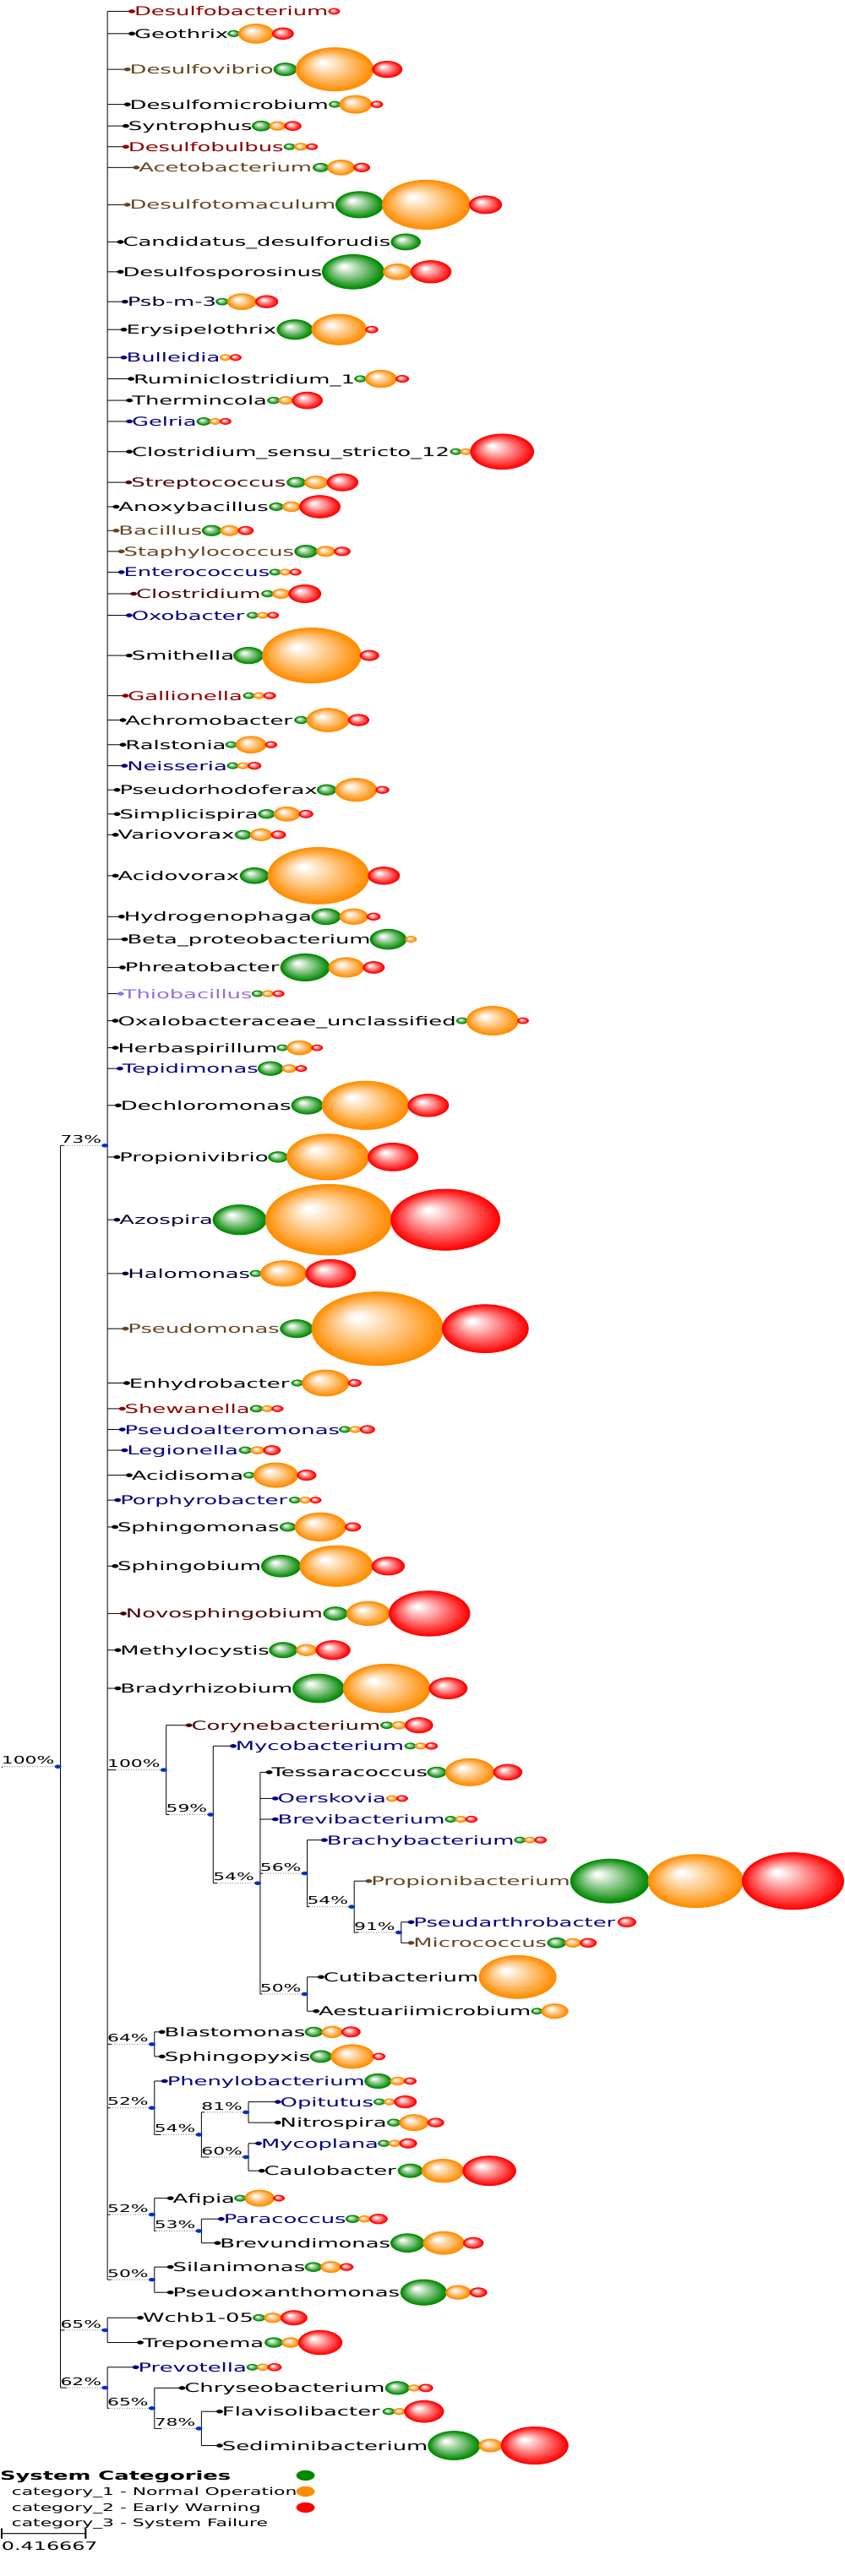

Missing discussion

## Galaxy Tree
### Extracting the Genera of core_usual_checked taxa dataframe

Making a new Visualisation type iTOL with ETE, using the data from Galaxy was no possible, so it was rendered on iTOL

In [ ]:
input_dir = Path("/home/beatriz/MIC/2_Micro/data_qiime")
input_galaxy = Path("/home/beatriz/MIC/data_galaxies")
newick_path =  input_galaxy / "Galaxy7-PICRUSt2-Full-pipeline-on-data-2-and-data-1-Tree-reference-study-16S-sequences.newick"
# Load tree
tree_galaxy = Phylo.read(newick_path, "newick")

output_base = Path("/home/beatriz/MIC/2_Micro/data_picrust/output_base")
otu_path = output_base / "otu_mapping.tsv"

otu_mapping = pd.read_csv(otu_path, sep="\t")
taxon_ids = otu_mapping["taxon"].tolist()

In [ ]:
# First get a list of terminal names to keep
filtered_names = set(str(taxon_id) for taxon_id in taxon_ids)

# Track which terminals to remove
terminals_to_remove = []
for terminal in tree_galaxy.get_terminals():
    if terminal.name not in filtered_names:
        terminals_to_remove.append(terminal)

# Remove unwanted terminals
for terminal in terminals_to_remove:
    tree_galaxy.prune(terminal)

filter_path = input_dir / "filtered_galaxy.newick"
# Write the pruned tree
Phylo.write(tree_galaxy, filter_path, "newick")

### Replacing the Taxon Names on the Galaxy Newick Tree

In [ ]:
# Read the pruned tree
with open(filter_path, 'r') as f:
    subtree_galaxy = f.read()

# Convert the mapping DataFrame to a dictionary for easier lookup
taxon_to_genus = dict(zip(otu_mapping['taxon'], otu_mapping['Genus']))
str_taxon_to_genus = {str(k): v for k, v in taxon_to_genus.items()}

# Define a function to replace taxon IDs with genus names
def replace_taxon_with_genus(match):
    taxon_id_str = (match.group(1))
    if taxon_id_str in str_taxon_to_genus:
        return str_taxon_to_genus[taxon_id_str] + ":"
    # Try integer matching as backup
    try:
        taxon_id_int = int(taxon_id_str)
        if taxon_id_int in taxon_to_genus:
            return taxon_to_genus[taxon_id_int] + ":"
    except (ValueError, TypeError):
        pass
    
    return match.group(0) 

# This pattern looks for numbers followed by a colon
pattern = r"[']?(\d+)[']?(?=:)"
# Replace IDs with genus names
subtreeG_galaxy = re.sub(pattern, replace_taxon_with_genus, subtree_galaxy)
# Write final tree
gen_tree_path = input_dir / "galaxy_tree.newick"
# Write tree with genus
with open(gen_tree_path, 'w') as f:
    f.write(subtreeG_galaxy)

In [ ]:
import io
# Create a tree object from the string
subtreeG_galaxy_string = Phylo.read(io.StringIO(subtreeG_galaxy), "newick")

# Create figure
plt.figure(figsize=(15, 25))  # Adjust size as needed
Phylo.draw(subtreeG_galaxy_string, do_show=True)
#t.savefig(input_dir / "simple_subtreeG_galaxy.png", dpi=300)
# plt.close()

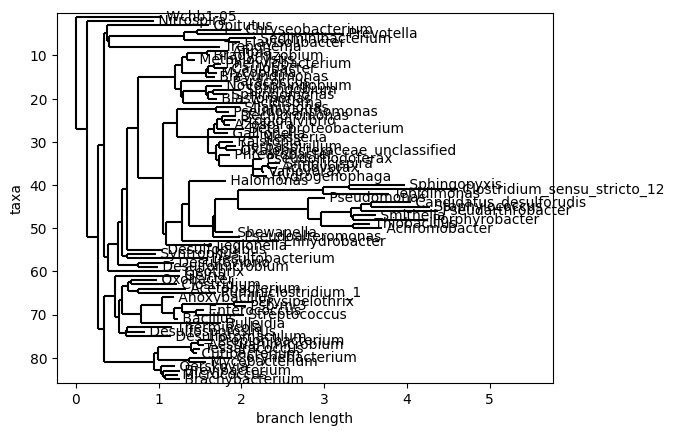

### Anotation Function for Itol

In [ ]:
def create_itol_barchart_file(aggregated_data, category_colors, categories, output_file, title="System Categories"):
    """
    Create iTOL multi-value bar chart data file from existing aggregated data

    Args:
        aggregated_data (dict): existing aggregated data dictionary
        category_colors (dict):  category color mappings
        categories (dict): category descriptions
        output_file (str): Path to save the iTOL annotation file
        title (str): Title for the dataset
    """
    # Convert hex colors to RGB values for iTOL
    def format_color(color):
        color = color.lower()
        if not color.startswith('#'):
            color = '#' + color
        return color

    # Color values need to be in hex format for iTOL
    formatted_colors = {k: format_color(v) for k, v in category_colors.items()}

    # Start building the file content
    lines = []

    # Add header with dataset information
    lines.append("DATASET_MULTIBAR")
    lines.append("SEPARATOR TAB")
    lines.append("DATASET_LABEL\tRelative Abundance by System Category")

    # Add color information for border
    lines.append("COLOR\t#000000")

    # Add field labels - use category descriptions
    field_labels = "\t".join([categories[cat_id] for cat_id in ['category_1', 'category_2', 'category_3']])
    lines.append(f"FIELD_LABELS\t{field_labels}")

    # Add field colors - use category colors
    field_colors = "\t".join([formatted_colors[cat_id] for cat_id in ['category_1', 'category_2', 'category_3']])
    lines.append(f"FIELD_COLORS\t{field_colors}")

    # Add additional formatting options that iTOL recognizes
    lines.append("MARGIN\t50")
    lines.append("WIDTH\t300")
    lines.append("HEIGHT_FACTOR\t0.8")

    # Start data section
    lines.append("DATA")

    # Add data for each genus using existing structure
    for genus, values in aggregated_data.items():

        # Skip if genus is a number
        if isinstance(genus, (int, float)) or (isinstance(genus, str) and genus.replace('.', '', 1).isdigit()):
            print(f"Skipping numeric genus identifier: {genus}")
            continue

        # Extract values for each category
        cat1 = values['category_1']
        cat2 = values['category_2']
        cat3 = values['category_3']

        # Only include genera with some data
        if cat1 > 0 or cat2 > 0 or cat3 > 0:
            lines.append(f"{genus}\t{cat1}\t{cat2}\t{cat3}")

    # Write to file
    with open(output_file, 'w', encoding= 'utf-8', newline='\n') as f:
        f.write("\n".join(lines))

    print(f"iTOL annotation file created at {output_file}")

# Define category colors with proper hex codes
category_colors = {
    'category_1': '#008800',  # Green
    'category_2': '#FF8C00',  # Orange
    'category_3': '#FF0000'   # Red
}

# Category descriptions
categories = {
    'category_1': 'Normal Operation',
    'category_2': 'Early Warning',
    'category_3': 'System Failure'
}


# Additionally, create a color strip annotation file for the bacterial sources
def create_itol_colorstrip_file(selected_taxa, output_file):
    """
    Create iTOL color strip annotation file for bacterial sources

    Args:
        selected_taxa (pd.DataFrame): DataFrame with taxa information including source
        output_file (str): Path to save the iTOL annotation file
    """
    # Define color mapping for bacterial sources
    source_colors = {
        'chk-core-us': '#4A0404',  # Deep burgundy for all three
        'chk-core': '#000033',     # Darker navy for checked+core
        'core-us': '#654321',      # Dark brown for core+usual
        'chk-us': '#9370DB',       # Purple for checked+usual
        'chk': '#000080',          # Navy blue for checked only
        'us': '#8B0000',           # Dark red for usual only
    }

    # Start building the file content
    lines = []

    # Add header with dataset information
    lines.append("DATASET_COLORSTRIP")
    lines.append("SEPARATOR TAB")
    lines.append("DATASET_LABEL\tBacterial Sources")

    # Add dataset scale factor
    lines.append("COLOR\t#000000")
    lines.append("WIDTH\t100")
    lines.append("MARGIN\t20")

    # Add legend information - correct iTOL format
    lines.append("LEGEND_TITLE\tSource Types")
    lines.append("LEGEND_SHAPES\t1\t1\t1\t1\t1\t1")
    lines.append("LEGEND_COLORS\t#4A0404\t#000033\t#654321\t#9370DB\t#000080\t#8B0000")
    lines.append("LEGEND_LABELS\tchk-core-us\tchk-core\tcore-us\tchk-us\tchk\tus")

    # Start data section
    lines.append("DATA")

    # Process each genus and its source - simplified approach
    for _, row in selected_taxa.iterrows():
        try:
            genus = row['Genus']
            if pd.isna(genus) or genus == "":
                continue

            source = "unknown"
            # Check if Source column exists and has a valid value
            if 'Source' in row and not pd.isna(row['Source']) and row['Source'] != "":
                source = str(row['Source']).lower()

            # Determine color based on source
            color = '#000000'  # Default black
            for src_type, src_color in source_colors.items():
                if src_type in source:
                    color = src_color
                    break

            # Write in proper iTOL format: NAME<tab>COLOR
            lines.append(f"{genus}\t{color}")
        except (IndexError, KeyError) as e:
            # Log errors but continue processing
            print(f"Error processing row: {e}")
            continue

    # Write to file - ensure proper line endings and encoding
    with open(output_file, 'w', encoding='utf-8', newline='\n') as f:
        f.write("\n".join(lines))

    print(f"iTOL color strip annotation file created at {output_file}")
    return output_file

# Additionally, here's a function to validate the colorstrip file format
def validate_colorstrip_file(file_path):
    """
    Check if colorstrip file follows proper iTOL format

    Args:
        file_path (str): Path to the iTOL colorstrip file

    Returns:
        bool: True if valid, False otherwise
    """
    required_headers = ["DATASET_COLORSTRIP", "SEPARATOR TAB", "DATA"]
    with open(file_path, 'r') as f:
        content = f.read()

    # Check for required headers
    for header in required_headers:
        if header not in content:
            print(f"Missing required header: {header}")
            return False

    # Check DATA section format
    data_section = content.split("DATA\n")[1] if "DATA\n" in content else ""
    if not data_section:
        print("No data found after DATA section")
        return False

    lines = data_section.strip().split("\n")
    for i, line in enumerate(lines, 1):
        if not line or line.isspace():
            continue
        if "\t" not in line:
            print(f"Line {i} in DATA section does not contain a tab separator: {line}")
            return False

        parts = line.split("\t")
        if len(parts) != 2:
            print(f"Line {i} in DATA section does not have exactly 2 tab-separated values: {line}")
            return False

        name, color = parts
        if not name or not color:
            print(f"Line {i} in DATA section has empty name or color: {line}")
            return False

        # Check if color is valid hex
        if color.startswith('#') and not all(c in "0123456789ABCDEFabcdef" for c in color[1:]):
            print(f"Line {i} has invalid hex color: {color}")
            return False

    print("Colorstrip file format appears valid")
    return True

In [ ]:
# Annotated data to Create iTOL multi-value bar chart file
create_itol_barchart_file(
    aggregated_data,
    category_colors,
    categories,
    str(output_galaxy / "itol_abundance_bars.txt"),
    "Relative Abundance by System Category"
)

# Create iTOL color strip file for bacterial sources
create_itol_colorstrip_file(
    selected_taxa,
    str(output_galaxy / "itol_bacterial_sources.txt")
)

validate_colorstrip_file(str(output_galaxy / "itol_bacterial_sources.txt"))